In [1]:
import sys
sys.path.append('/home/mhee7173/anaconda3/lib/python3.9/site-packages')
import matplotlib.pyplot as plt
import matplotlib.patches as patches

###
import numpy as np
import pandas as pd
# pd version < 1.4.4
import time
from collections import Counter
from itertools import product
import concurrent.futures
import signal, psutil, os
from concurrent.futures import ProcessPoolExecutor, ALL_COMPLETED,FIRST_COMPLETED, wait
import copy
from sklearn.cluster import KMeans

In [2]:
## Ra,Dec to focal plane projection

rtod = 180. / np.pi
dtor = np.pi / 180.

def Apply_distortion(xin 
		 ,a0 
		 ,a10, a01
		 ,a30, a21, a12, a03
		 ,a50, a41, a32, a23, a14, a05
		 ):
	"""
	Apply distortion to field angle
	input : xin = (xi, eta) in "degree" unit
	output : focal plane coordinate(x or y) in "mm" unit
	"""
	x, y = xin
	x2 = x**2; y2 = y**2;
	term = (
			a0  
			+ a10*x + a01*y 
			+ a30*(x**3) + a21*(x*x*y) + a12*(x*y*y) + a03*(y**3)
			+ a50*(x**5) + a41*(x2*x2*y) + a32*(x*x2*y2) + a23*(x2*y2*y) + a14*(x*y2*y2) + a05*(y**5)
			)
	return term

def TAN_projection(ra, dec, ra0, dec0):
	"""
	Apply TAN projection to sky coordinates
	input : (ra, dec = RA_gal, decl_gal) , (ra0, dec0 = RA_tile, decl_tile) in "radian" unit
	output : (xi, eta) in "degree" unit
	"""
	c = np.sin(dec0)*np.sin(dec) + np.cos(dec0)*np.cos(dec)*np.cos(ra-ra0)

	xi = rtod*np.cos(dec)*np.sin(ra-ra0) / c
	eta = rtod*(np.cos(dec0)*np.sin(dec)
		   -np.sin(dec0)*np.cos(dec)*np.cos(ra-ra0)) / c

	return xi, eta

# Distortion coefficients for KMTNet
xcoef = np.array([ 1.49970027e-11,  9.00539718e+01,  6.98512764e-07,  8.25505932e-01,
	   -1.19791323e-06,  8.16288712e-01, -1.54800136e-06,  4.75239683e-02,
		2.78002130e-07,  9.46774873e-02,  1.09582774e-06,  4.75061533e-02,
		7.08467795e-07])

ycoef = np.array([-1.60575680e-07,  1.71202489e-06,  9.00539718e+01, -1.16129101e-06,
		8.16288657e-01, -2.48438098e-06,  8.25505903e-01,  2.48866140e-08,
		4.75061800e-02,  1.64324774e-06,  9.46775306e-02,  1.29135998e-07,
		4.75239798e-02])


def TPV_WCS(ra, dec, ra0, dec0):
	"""
	Convert sky coordinates (ra, dec) to focal plane coordinates (x, y)
	input : (ra, dec = RA_gal, decl_gal) , (ra0, dec0 = RA_tile, decl_tile) in "degree" unit
	output : (x_focal, y_focal) in "mm" unit	
	"""
	xi, eta = TAN_projection(ra*dtor, dec*dtor, ra0*dtor, dec0*dtor)
	x_focal, y_focal = Apply_distortion((xi, eta), *xcoef), Apply_distortion((xi, eta), *ycoef)

	return x_focal, y_focal

In [3]:
## check beta arm crossing


def line2pointdist(p,a,b):
    s=((p[0]-a[0])*(b[0]-a[0])+(p[1]-a[1])*(b[1]-a[1]))/((a[0]-b[0])**2+(a[1]-b[1])**2)
    if (s>=0) & (s<=1) : 
        return np.sqrt(np.sum((a+s*(b-a)-p)**2))
    else :
        return min(np.sqrt(np.sum((a-p)**2)),np.sqrt(np.sum((b-p)**2)))
    
def divide_pt(a1,b1,a2,b2):
    f1= (b1[0]-a1[0])*(a2[1]-a1[1]) - (b1[1]-a1[1])*(a2[0]-a1[0])
    f2= (b1[0]-a1[0])*(b2[1]-a1[1]) - (b1[1]-a1[1])*(b2[0]-a1[0])
    if f1*f2 < 0 :
        return True
    else:
        return False

def line_cross(a1,b1,a2,b2):
    """
    Check that line element a1-b1 crosses line element a2-b2 
    """
    ff1 = divide_pt(a1,b1,a2,b2)
    ff2 = divide_pt(a2,b2,a1,b1)
    if ff1 and ff2:
        return True
    

In [4]:
## process 1 (assign fiber without regarding beta arm crossing)
def proc1(obj,fiber_pos,pre_assigned=None):

    obj_3=obj.copy(deep=True)
    fiber_pos_3=fiber_pos.copy(deep=True)
    obj_3['fiber_cand']=""
    obj_3_assigned=pd.DataFrame({"x":[],"y":[],"rank":[],"fiber_x":[],"fiber_y":[],"fiber_num":[],"flag":[]})
    if pre_assigned is not None:
        obj_3_assigned=obj_3_assigned.append(pre_assigned,ignore_index=True)
    
    obj_fib=[]
    for i in range(len(obj_3)):
        fib=[]
        idx=np.where((abs(np.array(fiber_pos_3['x'])-obj_3['x'][i])<=16.8) &(abs(np.array(fiber_pos_3['y'])-obj_3['y'][i])<=16.8))
        for j in idx[0]:
            dist=pow(fiber_pos_3['x'][j]-obj_3['x'][i],2)+pow(fiber_pos_3['y'][j]-obj_3['y'][i],2)
            if (dist>40.96) & (dist<282.24): #40.96=6.4^2 , 282.24=16.8^2
                fib.append(j)
        obj_fib.append(fib)
    
    if pre_assigned is not None:
        for i in obj_fib:
            for j in np.array(pre_assigned['fiber_num']):
                if j-1 in i:
                    i.remove(j-1)
        
    
    obj_3['fiber_cand']=obj_fib ### 3 rev.
    
    objjj=[]
    for i in range(len(fiber_pos_3)):
        objj=[]
        idx=np.where((abs(np.array(obj_3['x'])-fiber_pos_3['x'][i])<=16.8) &(abs(np.array(obj_3['y'])-fiber_pos_3['y'][i])<=16.8))
        for j in idx[0]:
            dist=pow(fiber_pos_3['x'][i]-obj_3['x'][j],2)+pow(fiber_pos_3['y'][i]-obj_3['y'][j],2)
            if (dist>40.96) & (dist<282.24): #40.96=6.4^2 , 282.24=16.8^2
                objj.append(j)
        objjj.append(objj)
        
    if pre_assigned is not None:
        for j in np.array(pre_assigned['fiber_num']):
            objjj[int(j-1)]=[]

    fiber_pos_3['obj_cand']=objjj

    fib_obj_copy=copy.deepcopy(objjj)

    ####
    obj_fib_copy=copy.deepcopy(obj_fib)    
    
    rank_3=np.array(obj_3['rank'])
    assi_obj=len(obj_3)+10

    fib_idx=-1
    while True :
        fib_num=[]
        for i in range(len(obj_fib_copy)):
            if fib_idx in obj_fib_copy[i]:
                obj_fib_copy[i].remove(fib_idx)
            fib_num.append(len(obj_fib_copy[i]))
        
        fib_num_max=max(fib_num)
        if fib_num_max==0:
            break
        it=0
        while True:
            it+=1
            idx_fib_num_min=np.where(np.array(fib_num)==it)
            if len(idx_fib_num_min[0]!=0): break
        
        fib_num_min=it
        idx_min=np.where(np.array(fib_num)==fib_num_min)
        iidx=idx_min[0][np.where(rank_3[idx_min]==min(rank_3[idx_min]))[0][0]]
        fib_idx_cand=obj_fib_copy[iidx]
        fib_can_len=[]
        for i in fib_idx_cand:
            fib_can_len.append(len(fib_obj_copy[i]))
        fib_can_len=np.array(fib_can_len)
        fib_can_len_idx=np.where(fib_can_len==min(fib_can_len))
        if len(fib_can_len_idx[0])==1:
            fib_idx=obj_fib_copy[iidx][fib_can_len_idx[0][0]]
        else:
            if len(obj_3_assigned)!=0:
                dist_cond=[]
                for i in range(len(fib_can_len_idx[0])):
                    fib_x=np.array(obj_3_assigned['fiber_x'])
                    fib_y=np.array(obj_3_assigned['fiber_y']) 
                    fib_idx_2=obj_fib_copy[iidx][fib_can_len_idx[0][i]]
                    dist=sum(1/(pow(fib_x-fiber_pos['x'][fib_idx_2],2)+pow(fib_y-fiber_pos['y'][fib_idx_2],2)))
                    dist_cond.append(dist)
                iidx2=np.where(np.array(dist_cond)==min(dist_cond))[0][0]
                fib_idx=obj_fib_copy[iidx][fib_can_len_idx[0][iidx2]]
            else:    
                fib_idx=obj_fib_copy[iidx][fib_can_len_idx[0][0]]    
        new_dat={"x":obj_3['x'][iidx],"y":obj_3['y'][iidx],"rank":rank_3[iidx],"fiber_x":fiber_pos_3['x'][fib_idx],"fiber_y":fiber_pos_3['y'][fib_idx],"fiber_num":fib_idx+1}
        obj_3_assigned=obj_3_assigned.append(new_dat,ignore_index=True)
        obj_fib_copy[iidx]=[]
        
        
    obj_3_x=np.array(obj_3['x'])
    obj_3_y=np.array(obj_3['y'])
    obj_assi_x=np.array(obj_3_assigned['x'])
    obj_assi_y=np.array(obj_3_assigned['y'])
    obj_assi_idx=[]
    obj_assi_flag=np.array(obj_3_assigned['flag'])
    nan_idx=np.where(np.isnan(obj_assi_flag)==True)
    for i in nan_idx[0]:
        obj_assi_idx.append(np.where((obj_3_x==obj_assi_x[i])&(obj_3_y==obj_assi_y[i]))[0][0])  
    if pre_assigned is not None:
        obj_assi_idx_nan=np.array(obj_3_assigned['idx'])
        obj_assi_idx_nan[nan_idx]=obj_assi_idx
        obj_3_assigned['idx']=obj_assi_idx_nan
    else :
        obj_3_assigned['idx']=obj_assi_idx
    return obj_3_assigned,fiber_pos_3,obj_3        
    


In [5]:
# calculating group (beta arm crossed)
def proc2(obj_3,obj_3_assigned,fiber_pos_3,alpha_length=5.2,beta_length=11.6,col_cond=3):
    xx=np.array(obj_3_assigned['x']-obj_3_assigned['fiber_x'])
    yy=np.array(obj_3_assigned['y']-obj_3_assigned['fiber_y'])
    r=np.sqrt(xx*xx+yy*yy)
    ang=np.arctan2(yy,xx)

    beta=np.arccos((r*r-alpha_length**2-beta_length**2)/2/alpha_length/beta_length)  # 0 ~ pi
    alpha=ang-np.arccos((alpha_length+beta_length*np.cos(beta))/r) # -pi ~ pi

    group=[]
    adj_fib=list(fiber_pos_3['adj_fib_idx'])
    assigned_fib_num=list(obj_3_assigned['fiber_num'])
    
    for i in range(len(obj_3_assigned)):
        x1=obj_3_assigned['fiber_x'][i]
        y1=obj_3_assigned['fiber_y'][i]
        a1=np.array([x1+np.cos(alpha[i])*alpha_length,y1+np.sin(alpha[i])*alpha_length])
        b1=np.array([x1+np.cos(alpha[i])*alpha_length+np.cos(beta[i]+alpha[i])*beta_length,y1+np.sin(alpha[i])*alpha_length+np.sin(beta[i]+alpha[i])*beta_length])

        for j in range(i+1,len(assigned_fib_num)):
            
            ind=adj_fib[int(assigned_fib_num[i]-1)].copy()
            ind.append(int(assigned_fib_num[j]-1))
            
            if len(ind)!= len(set(ind)):
                x2=obj_3_assigned['fiber_x'][j]
                y2=obj_3_assigned['fiber_y'][j]  
                a2=np.array([x2+np.cos(alpha[j])*alpha_length,y2+np.sin(alpha[j])*alpha_length])
                b2=np.array([x2+np.cos(alpha[j])*alpha_length+np.cos(beta[j]+alpha[j])*beta_length,y2+np.sin(alpha[j])*alpha_length+np.sin(beta[j]+alpha[j])*beta_length])

                if line_cross(a1,b1,a2,b2) : dist=[0,0,0,0]

                else :
                    dist=[line2pointdist(a1,a2,b2)
                         ,line2pointdist(a2,a1,b1)
                         ,line2pointdist(b1,a2,b2)
                         ,line2pointdist(b2,a1,b1)]


                if (dist[0]<(col_cond*np.sqrt(2)+col_cond)/2) | (dist[1]<(col_cond*np.sqrt(2)+col_cond)/2) | (dist[2]<col_cond) | (dist[3]<col_cond):

                    count=0
                    fib_cand=[int(assigned_fib_num[i]-1),int(assigned_fib_num[j]-1)]
                    
                    for k in range(len(group)):
                        a=group[k].copy()
                        a.extend(fib_cand)
                        if len(np.unique(a))!=len(np.unique(group[k]))+len(np.unique(fib_cand)):
                            group[k].extend(fib_cand)
                            count+=1

                    if count==0:
                        group.append(fib_cand)
                 
    obj_assi_fibnum=np.array(obj_3_assigned['fiber_num'])
    
    obj_3_x=np.array(obj_3['x'])
    obj_3_y=np.array(obj_3['y'])
    obj_assi_x=np.array(obj_3_assigned['x'])
    obj_assi_y=np.array(obj_3_assigned['y'])
    obj_assi_idx=np.array(obj_3_assigned['idx'])   
    obj_assi_nan_idx=np.where(np.isnan(obj_3_assigned['flag']))
    obj_assi_idx_nan=[]
    for i in obj_assi_nan_idx[0]:
        obj_assi_idx_nan.append(np.where((obj_3_x==obj_assi_x[i])&(obj_3_y==obj_assi_y[i]))[0][0])  
    obj_assi_idx[obj_assi_nan_idx]=obj_assi_idx_nan
        
    for i in range(len(group)):
        group[i]=np.unique(group[i])
        
    for i in range(len(group)):
        for j in group[i]:
            if not np.isnan(obj_3_assigned.iloc[np.where(obj_assi_fibnum==j+1)[0][0]]['flag']):
                group[i]=np.delete(group[i],np.where(group[i]==j))

    for i in range(len(group)):
        group_add=[]
        for j in group[i]:
            iidx=np.where(obj_assi_fibnum==j+1)[0] #assign 된 fiber num이 group
            fib_cand_op=obj_3.iloc[int(obj_assi_idx[iidx[0]])]['fiber_cand']
            for k in fib_cand_op:
                if k+1 not in obj_assi_fibnum:
                    group_add.append(k)
                
        group[i]=np.append(group[i],group_add)
        group[i]=np.unique(group[i])
        
    for i in range(len(group)):
        group[i]=np.unique(group[i])   
        
    while True:
        if len(group)<=1:
            break        
        ii=0
        for i in range(len(group)):
            for j in range(i+1,len(group)):
                gg=np.concatenate((group[i],group[j]))
                if len(gg)!=len(set(gg)):
                    group.pop(j)
                    group.pop(i)
                    group.append(np.unique(gg))
                    ii=1
                    break
            if ii:
                break

        if (i==len(group)-1) & (j==len(group)-1):
            break        
        
    return group

In [6]:
def kill_child_processes(parent_pid, sig=signal.SIGTERM):
    try:
        parent = psutil.Process(parent_pid)
        
        children = parent.children(recursive=True)
        for process in children:
            process.send_signal(sig)    
            
    except psutil.NoSuchProcess:
        return
    
def collision_list(obj_3,fib_op,adj_fib,fiber_pos_3,items,alpha_length=5.2,beta_length=11.6,col_cond=3):
    col_list=[]
        
    fib_op=np.asarray(fib_op)
    fib_op=fib_op.astype(np.int64)
        
    for i in range(len(fib_op)):
        for j in range(i+1,len(fib_op)):
            cond_len=copy.deepcopy(adj_fib[fib_op[i]])
            cond_len.append(fib_op[j])
            if len(cond_len)!=len(set(cond_len)):
                for k in items[i]:
                    for l in items[j]:
                        if (k!=l)&(k>0)&(l>0):
                            x1=fiber_pos_3['x'][fib_op[i]]
                            y1=fiber_pos_3['y'][fib_op[i]]
                            xx=np.array(obj_3['x'][k]-x1)
                            yy=np.array(obj_3['y'][k]-y1)
                            r=np.sqrt(xx*xx+yy*yy)
                            ang=np.arctan2(yy,xx)
                            beta=np.arccos((r*r-alpha_length**2-beta_length**2)/2/alpha_length/beta_length)  # 0 ~ pi
                            alpha=ang-np.arccos((alpha_length+beta_length*np.cos(beta))/r) # -pi ~ pi              
                            a1=np.array([x1+np.cos(alpha)*alpha_length,y1+np.sin(alpha)*alpha_length])
                            b1=np.array([x1+np.cos(alpha)*alpha_length+np.cos(beta+alpha)*beta_length,y1+np.sin(alpha)*alpha_length+np.sin(beta+alpha)*beta_length])

                            x2=fiber_pos_3['x'][fib_op[j]]
                            y2=fiber_pos_3['y'][fib_op[j]]
                            xx=np.array(obj_3['x'][l]-x2)
                            yy=np.array(obj_3['y'][l]-y2)
                            r=np.sqrt(xx*xx+yy*yy)
                            ang=np.arctan2(yy,xx)
                            beta=np.arccos((r*r-alpha_length**2-beta_length**2)/2/alpha_length/beta_length) # 0 ~ pi
                            alpha=ang-np.arccos((alpha_length+beta_length*np.cos(beta))/r) # -pi ~ pi              
                            a2=np.array([x2+np.cos(alpha)*alpha_length,y2+np.sin(alpha)*alpha_length])
                            b2=np.array([x2+np.cos(alpha)*alpha_length+np.cos(beta+alpha)*beta_length,y2+np.sin(alpha)*alpha_length+np.sin(beta+alpha)*beta_length])
                            if line_cross(a1,b1,a2,b2) : dist=[0,0,0,0]

                            else :
                                dist=[line2pointdist(a1,a2,b2)
                                        ,line2pointdist(a2,a1,b1)
                                        ,line2pointdist(b1,a2,b2)
                                        ,line2pointdist(b2,a1,b1)]

                            if (dist[0]<(col_cond*np.sqrt(2)+col_cond)/2) | (dist[1]<(col_cond*np.sqrt(2)+col_cond)/2) | (dist[2]<col_cond) | (dist[3]<col_cond):
                                coll=np.zeros(len(fib_op))
                                coll[i]=k
                                coll[j]=l
                                col_list.append(coll)
                        elif (k==l):
                            coll=np.zeros(len(fib_op))
                            coll[i]=k
                            coll[j]=k
                            col_list.append(coll)                            
    col_list=np.asarray(col_list)
    return col_list

In [7]:
def col_av(combinations,assi_len,col_list):
    if len(col_list)==0:
        for i in range(len(combinations)):
            it=len(np.where(combinations[i]>0)[0])
            assi_len[i]=it
        
        return combinations,assi_len
       
    else :
        b=combinations
        c=assi_len
        for i in range(len(col_list)):
            a=col_list[i]
            #idx=np.where(sum((b*a-a*a).T)!=0)
            idx = ~np.all(b*a-a*a == 0, axis=1)
            b=b[idx]
            c=c[idx]
            
        for i in range(len(b)):
            c[i]=len(np.where(b[i]>0)[0])
            
        if len(c)==0:
            return np.array([-1*np.ones(len(combinations[0]))]),np.zeros(1)
        else:
            return b,c


In [8]:
def set_group_boundary(fiber_pos_3,ggroup,subgroup_idx):
    ggroup=np.array(ggroup)
    boundary=[]
    fiber0_x,fiber0_y=[],[]
    fiber1_x,fiber1_y=[],[]

    idx0=np.where(subgroup_idx==0)
    idx1=np.where(subgroup_idx==1)

    for i in ggroup[idx0]:
        fiber0_x.append(fiber_pos_3['x'][i])
        fiber0_y.append(fiber_pos_3['y'][i])
    for i in ggroup[idx1]:
        fiber1_x.append(fiber_pos_3['x'][i])
        fiber1_y.append(fiber_pos_3['y'][i])

    fiber0_x=np.array(fiber0_x)
    fiber0_y=np.array(fiber0_y)
    fiber1_x=np.array(fiber1_x)
    fiber1_y=np.array(fiber1_y)    
    if len(fiber0_x)>len(fiber1_x):
        for i in range(len(fiber0_x)):
            dist=pow(fiber1_y-fiber0_y[i],2)+pow(fiber1_x-fiber0_x[i],2)
            if min(dist)<850:
                boundary.append(ggroup[idx0][i])
    else:
        for i in range(len(fiber1_x)):
            dist=pow(fiber0_y-fiber1_y[i],2)+pow(fiber0_x-fiber1_x[i],2)
            if min(dist)<850:
                boundary.append(ggroup[idx1][i])

    boundary=np.array(boundary)
    return boundary

In [9]:

def col_av2(obj_3,obj_3_assigned,subgroup_idx,boundary_idx,boundary,boundary_combinations,fib_op,items,fiber_pos_3,adj_fib,alpha_length=5.2,beta_length=11.6,col_cond=3):
    obj_assi_fibnum=np.array(obj_3_assigned['fiber_num'])
    obj_assi_idx=np.array(obj_3_assigned['idx'])
    ###
    idx1=np.where(subgroup_idx==1)
    idx1_nb=np.setdiff1d(idx1[0],boundary_idx)

    items1=[]
    fib1_op=[]
    for i in range(len(idx1_nb)):
        items1.append(items[idx1_nb[i]])
        fib1_op.append(fib_op[idx1_nb[i]])

    result1_combinations,result1_assi_len=[],[]

    result1_combinations_list,result1_assi_len_list=[],[]
    items11_list=[]
    ###
    idx0=np.where(subgroup_idx==0)
    idx0_nb=np.setdiff1d(idx0[0],boundary_idx)

    items0=[]
    fib0_op=[]
    for i in range(len(idx0_nb)):
        items0.append(items[idx0_nb[i]])
        fib0_op.append(fib_op[idx0_nb[i]])

    result_combinations,result_assi_len=[],[]

    result_combinations_list,result_assi_len_list=[],[]
    items00_list=[]
### orig
    orig0=[]
    for i in fib0_op:
        idx=np.where(obj_assi_fibnum==i+1)
        if len(idx[0])!=0:
            orig0.append(np.array(obj_assi_idx)[idx][0])
        else :
            orig0.append(0)     
    orig0=np.array(orig0)
    orig1=[]
    for i in fib1_op:
        idx=np.where(obj_assi_fibnum==i+1)
        if len(idx[0])!=0:
            orig1.append(np.array(obj_assi_idx)[idx][0])
        else :
            orig1.append(0)      
    orig1=np.array(orig1)
###    
    for k in range(len(boundary_combinations)):
    ###   
        item1_remove=[]
        for i in range(len(idx1_nb)):
            item1_remove.append([])
    ###
        item0_remove=[]
        for i in range(len(idx0_nb)):
            item0_remove.append([])

        obj_op_boundary=pd.DataFrame({"x":[],"y":[],"rank":[],"fiber_x":[],"fiber_y":[],"fiber_num":[]})
        for i in range(len(boundary)):
            obj_b_idx=boundary_combinations[k][i]
            if obj_b_idx>0:
                new_dat={"x":obj_3['x'][obj_b_idx],"y":obj_3['y'][obj_b_idx],"rank":obj_3['rank'][obj_b_idx]
                         ,"fiber_x":fiber_pos_3['x'][boundary[i]],"fiber_y":fiber_pos_3['y'][boundary[i]],"fiber_num":boundary[i]+1}
                obj_op_boundary=obj_op_boundary.append(new_dat,ignore_index=True)             
    ###
        for i in range(len(fib1_op)):
            for j in range(len(items1[i])-1):
                groupi=obj_op_boundary.copy()
                objjjj=obj_3.iloc[items1[i][j]]
                fib=fiber_pos_3.iloc[int(fib1_op[i])]
                new_dat={"x":objjjj['x'],"y":objjjj['y'],"rank":objjjj['rank'],"fiber_x":fib['x'],"fiber_y":fib['y'],"fiber_num":fib1_op[i]+1}
                groupi=groupi.append(new_dat,ignore_index=True)
                groupi_fib_num=list(groupi['fiber_num'])                

                xx=np.array(groupi['x']-groupi['fiber_x'])
                yy=np.array(groupi['y']-groupi['fiber_y'])
                r=np.sqrt(xx*xx+yy*yy)
                ang=np.arctan2(yy,xx)

                beta=np.arccos((r*r-alpha_length**2-beta_length**2)/2/alpha_length/beta_length)  # 0 ~ pi
                alpha=ang-np.arccos((alpha_length+beta_length*np.cos(beta))/r) # -pi ~ pi        

                x1=groupi['fiber_x'][len(groupi)-1]
                y1=groupi['fiber_y'][len(groupi)-1]
                a1=np.array([x1+np.cos(alpha[len(groupi)-1])*alpha_length,y1+np.sin(alpha[len(groupi)-1])*alpha_length])
                b1=np.array([x1+np.cos(alpha[len(groupi)-1])*alpha_length+np.cos(beta[len(groupi)-1]+alpha[len(groupi)-1])*beta_length,y1+np.sin(alpha[len(groupi)-1])*alpha_length+np.sin(beta[len(groupi)-1]+alpha[len(groupi)-1])*beta_length])

                for l in range(len(groupi)-1):
                    ind=adj_fib[int(groupi_fib_num[len(groupi)-1]-1)].copy()
                    ind.append(int(groupi_fib_num[l]-1))

                    if len(ind)!= len(set(ind)): 
                        x2=groupi['fiber_x'][l]
                        y2=groupi['fiber_y'][l]  
                        a2=np.array([x2+np.cos(alpha[l])*alpha_length,y2+np.sin(alpha[l])*alpha_length])
                        b2=np.array([x2+np.cos(alpha[l])*alpha_length+np.cos(beta[l]+alpha[l])*beta_length,y2+np.sin(alpha[l])*alpha_length+np.sin(beta[l]+alpha[l])*beta_length])

                        if line_cross(a1,b1,a2,b2) : dist=[0,0,0,0]

                        else :
                            dist=[line2pointdist(a1,a2,b2)
                                    ,line2pointdist(a2,a1,b1)
                                    ,line2pointdist(b1,a2,b2)
                                    ,line2pointdist(b2,a1,b1)]

                        if (dist[0]<(col_cond*np.sqrt(2)+col_cond)/2) | (dist[1]<(col_cond*np.sqrt(2)+col_cond)/2) | (dist[2]<col_cond) | (dist[3]<col_cond):
                            item1_remove[i].append(items1[i][j])
                            break        
    ###                        

        for i in range(len(fib0_op)):
            for j in range(len(items0[i])-1):
                groupi=obj_op_boundary.copy()
                objjjj=obj_3.iloc[items0[i][j]]
                fib=fiber_pos_3.iloc[int(fib0_op[i])]
                new_dat={"x":objjjj['x'],"y":objjjj['y'],"rank":objjjj['rank'],"fiber_x":fib['x'],"fiber_y":fib['y'],"fiber_num":fib0_op[i]+1}
                groupi=groupi.append(new_dat,ignore_index=True)
                groupi_fib_num=list(groupi['fiber_num'])                

                xx=np.array(groupi['x']-groupi['fiber_x'])
                yy=np.array(groupi['y']-groupi['fiber_y'])
                r=np.sqrt(xx*xx+yy*yy)
                ang=np.arctan2(yy,xx)

                beta=np.arccos((r*r-alpha_length**2-beta_length**2)/2/alpha_length/beta_length)  # 0 ~ pi
                alpha=ang-np.arccos((alpha_length+beta_length*np.cos(beta))/r) # -pi ~ pi        

                x1=groupi['fiber_x'][len(groupi)-1]
                y1=groupi['fiber_y'][len(groupi)-1]
                a1=np.array([x1+np.cos(alpha[len(groupi)-1])*alpha_length,y1+np.sin(alpha[len(groupi)-1])*alpha_length])
                b1=np.array([x1+np.cos(alpha[len(groupi)-1])*alpha_length+np.cos(beta[len(groupi)-1]+alpha[len(groupi)-1])*beta_length,y1+np.sin(alpha[len(groupi)-1])*alpha_length+np.sin(beta[len(groupi)-1]+alpha[len(groupi)-1])*beta_length])

                for l in range(len(groupi)-1):
                    ind=adj_fib[int(groupi_fib_num[len(groupi)-1]-1)].copy()
                    ind.append(int(groupi_fib_num[l]-1))

                    if len(ind)!= len(set(ind)): 
                        x2=groupi['fiber_x'][l]
                        y2=groupi['fiber_y'][l]  
                        a2=np.array([x2+np.cos(alpha[l])*alpha_length,y2+np.sin(alpha[l])*alpha_length])
                        b2=np.array([x2+np.cos(alpha[l])*alpha_length+np.cos(beta[l]+alpha[l])*beta_length,y2+np.sin(alpha[l])*alpha_length+np.sin(beta[l]+alpha[l])*beta_length])

                        if line_cross(a1,b1,a2,b2) : dist=[0,0,0,0]

                        else :
                            dist=[line2pointdist(a1,a2,b2)
                                    ,line2pointdist(a2,a1,b1)
                                    ,line2pointdist(b1,a2,b2)
                                    ,line2pointdist(b2,a1,b1)]

                        if (dist[0]<(col_cond*np.sqrt(2)+col_cond)/2) | (dist[1]<(col_cond*np.sqrt(2)+col_cond)/2) | (dist[2]<col_cond) | (dist[3]<col_cond):
                            item0_remove[i].append(items0[i][j])
                            break        


        items00=copy.deepcopy(items0)

        for i in range(len(item0_remove)):
            for j in item0_remove[i]:
                items00[i].remove(j)     
    ###
        items11=copy.deepcopy(items1)

        for i in range(len(item1_remove)):
            for j in item1_remove[i]:
                items11[i].remove(j)   
    ###    
        if len(items00_list)==0:
            items00_list.append(items00)
            col_list00=collision_list(obj_3,fib0_op,adj_fib,fiber_pos_3,items00,alpha_length,beta_length,col_cond)
            combinations00=np.array(list(product(*items00)))   
            assi_len00=np.zeros(len(combinations00))
            result_comb,result_len=col_av(combinations00,assi_len00,col_list00)

            if max(result_len)==0:
                a=[]
                for i in range(len(fib0_op)):
                    a.append(-1)
                result_combinations.append(a)
                result_assi_len.append(0)
                result_combinations_list.append(a)
                result_assi_len_list.append(0)
            else:
                idx=np.where(result_len==max(result_len))
                comb=result_comb[idx]
                comb_orig=np.append(np.where(comb-orig0!=0)[0],np.arange(0,len(comb)))
                comb_cond=np.array(Counter(comb_orig).most_common())
                comb2=comb[comb_cond.T[0][np.where(comb_cond.T[1]==min(comb_cond.T[1]))[0][0]]]  
                
                result_combinations.append(comb2)
                result_assi_len.append(int(max(result_len)))
                result_combinations_list.append(comb2)
                result_assi_len_list.append(int(max(result_len)))         

        else:
            iidx=-1
            for i in range(len(items00_list)):
                if (items00_list[i]==items00) & (iidx==-1):
                    iidx=i
                    result_combinations.append(result_combinations_list[i])
                    result_assi_len.append(result_assi_len_list[i])
                    break

            if iidx==-1:
                items00_list.append(items00)
                col_list00=collision_list(obj_3,fib0_op,adj_fib,fiber_pos_3,items00,alpha_length,beta_length,col_cond)
                combinations00=np.array(list(product(*items00)))   
                assi_len00=np.zeros(len(combinations00))
                result_comb,result_len=col_av(combinations00,assi_len00,col_list00)

                if max(result_len)==0:
                    a=[]
                    for i in range(len(fib0_op)):
                        a.append(-1)
                    result_combinations.append(a)
                    result_assi_len.append(0)
                    result_combinations_list.append(a)
                    result_assi_len_list.append(0)
                else:
                    idx=np.where(result_len==max(result_len))
                    comb=result_comb[idx]
                    comb_orig=np.append(np.where(comb-orig0!=0)[0],np.arange(0,len(comb)))
                    comb_cond=np.array(Counter(comb_orig).most_common())
                    comb2=comb[comb_cond.T[0][np.where(comb_cond.T[1]==min(comb_cond.T[1]))[0][0]]]  

                    result_combinations.append(comb2)
                    result_assi_len.append(int(max(result_len)))
                    result_combinations_list.append(comb2)
                    result_assi_len_list.append(int(max(result_len)))             
    ###
        if len(items11_list)==0:
            items11_list.append(items11)
            col_list11=collision_list(obj_3,fib1_op,adj_fib,fiber_pos_3,items11,alpha_length,beta_length,col_cond)
            combinations11=np.array(list(product(*items11)))   
            assi_len11=np.zeros(len(combinations11))
            result1_comb,result1_len=col_av(combinations11,assi_len11,col_list11)

            if max(result1_len)==0:
                a=[]
                for i in range(len(fib1_op)):
                    a.append(-1)
                result1_combinations.append(a)
                result1_assi_len.append(0)
                result1_combinations_list.append(a)
                result1_assi_len_list.append(0)
            else:
                idx=np.where(result1_len==max(result1_len))
                comb=result1_comb[idx]
                comb_orig=np.append(np.where(comb-orig1!=0)[0],np.arange(0,len(comb)))
                comb_cond=np.array(Counter(comb_orig).most_common())
                comb2=comb[comb_cond.T[0][np.where(comb_cond.T[1]==min(comb_cond.T[1]))[0][0]]]  

                result1_combinations.append(comb2)
                result1_assi_len.append(int(max(result1_len)))
                result1_combinations_list.append(comb2)
                result1_assi_len_list.append(int(max(result1_len)))         

        else:
            iidx=-1
            for i in range(len(items11_list)):
                if (items11_list[i]==items11) & (iidx==-1):
                    iidx=i
                    result1_combinations.append(result1_combinations_list[i])
                    result1_assi_len.append(result1_assi_len_list[i])
                    break

            if iidx==-1:
                items11_list.append(items11)
                col_list11=collision_list(obj_3,fib1_op,adj_fib,fiber_pos_3,items11,alpha_length,beta_length,col_cond)
                combinations11=np.array(list(product(*items11)))   
                assi_len11=np.zeros(len(combinations11))
                result1_comb,result1_len=col_av(combinations11,assi_len11,col_list11)

                if max(result1_len)==0:
                    a=[]
                    for i in range(len(fib1_op)):
                        a.append(-1)
                    result1_combinations.append(a)
                    result1_assi_len.append(0)
                    result1_combinations_list.append(a)
                    result1_assi_len_list.append(0)
                else:
                    idx=np.where(result1_len==max(result1_len))
                    comb=result1_comb[idx]
                    comb_orig=np.append(np.where(comb-orig1!=0)[0],np.arange(0,len(comb)))
                    comb_cond=np.array(Counter(comb_orig).most_common())
                    comb2=comb[comb_cond.T[0][np.where(comb_cond.T[1]==min(comb_cond.T[1]))[0][0]]]  

                    result1_combinations.append(comb2)
                    result1_assi_len.append(int(max(result1_len)))
                    result1_combinations_list.append(comb2)
                    result1_assi_len_list.append(int(max(result1_len)))             

    ###    
    return fib0_op,fib1_op,result_combinations,result_assi_len,result1_combinations,result1_assi_len

In [10]:
def group_thread_assign(group,thread_num,fiber_pos_3,fibb2=None,fibb2_items=None):
    if fibb2:
        obj_cand=fibb2_items
        group_weight=[]
        group_tot=0
        for i in group:
            weight=1
            for ii in i:
                idx=np.where(np.array(fibb2)==ii)[0][0]
                weight*=len(fibb2_items[idx])
            weight=np.log(weight+1)
            group_weight.append(weight)
            group_tot+=weight


    
    else:
        obj_cand=np.array(fiber_pos_3['obj_cand'])
        group_weight=[]
        group_tot=0
        for i in group:
            weight=1
            for ii in i:
                weight*=len(obj_cand[int(ii)])
            weight=np.log(weight+1)
            group_weight.append(weight)
            group_tot+=weight

    thread_cond=len(group)/thread_num

    if thread_cond==1:
        thread_op=np.ones(len(group),dtype=int)
        group_op=[]
        for i in group:
            group_op.append([i])
    elif thread_cond<1:# group의 수 < thread 수
        group_op=[]
        for i in group:
            group_op.append([i])    

        thread_cond2=group_tot/thread_num
        thread_op=np.ones(len(group_op))
        thread_op+=np.rint(np.array(group_weight)-thread_cond2)
        idx=np.where(thread_op<1)
        thread_op[idx]=1
        while True:
            if sum(thread_op)==thread_num:
                 break
            elif sum(thread_op)<thread_num:
                cond=group_weight-thread_op*thread_cond2
                idx=np.where(cond==max(cond))[0][0]
                thread_op[idx]+=1
            else :
                cond=group_weight-thread_op*thread_cond2
                idx1=np.where(thread_op>1)
                idx2=np.where(cond[idx1]==min(cond[idx1]))[0][0]
                thread_op[idx1[0][idx2]]-=1   

        thread_op=thread_op.astype(int)

    else:# group의 수 > thread 수
        ggroup=group.copy()
        group_weight=np.array(group_weight)
        thread_op=np.ones(thread_num,dtype=int)
        group_op=[]
        for i in range(thread_num):
            group_op.append([])
        group_op_len=np.zeros(thread_num)
        for i in range(len(group)):
            idx1=np.where(group_op_len==min(group_op_len))[0][0]
            idx2=np.where(group_weight==max(group_weight))[0][0]
            group_op_len[idx1]+=group_weight[idx2]
            group_op[idx1].append(ggroup[idx2])
            del ggroup[idx2]
            group_weight=np.delete(group_weight,idx2)
            
    return group_op, thread_op


In [11]:

def group_proc3(group_op_i,thread_op_i,obj_3,obj_3_assigned,thread_num,max_loop=1e7,alpha_length=5.2,beta_length=11.6,col_cond=3):
    group_comb=[]
    group_fib=[]
    obj_3_x=np.array(obj_3['x'])
    obj_3_y=np.array(obj_3['y'])
    obj_assi_x=np.array(obj_3_assigned['x'])
    obj_assi_y=np.array(obj_3_assigned['y'])
    obj_assi_fibnum=np.array(obj_3_assigned['fiber_num'])
    obj_assi_idx=obj_3_assigned['idx']
    obj_assi_flag=np.isnan(obj_3_assigned['flag'])

    for m in range(len(group_op_i)):
        fib_op=list(group_op_i[m].copy())

        fib_op_x,fib_op_y=[],[]
        for i in fib_op:
            fib_op_x.append(fiber_pos_3['x'][i])
            fib_op_y.append(fiber_pos_3['y'][i])
        fib_op_x=np.array(fib_op_x)
        fib_op_y=np.array(fib_op_y)

        for i in range(len(fib_op)):
            ddist=pow(obj_assi_x-fib_op_x[i],2)+pow(obj_assi_y-fib_op_y[i],2)
            idx=np.where((ddist<16.8*16.8)&obj_assi_flag)
            fib_op.extend(list(obj_assi_fibnum[idx]-1))
        fib_op=np.unique(fib_op)    

        fib_op_adj=[]
        items = []
        assi_idx_opfib=[]                  
        for i in range(len(fib_op)):  
            items.append(fiber_pos_3['obj_cand'][fib_op[i]].copy())
            items[i].append(-1-i) # negative sign: unassigned fiber
            fib_op_adj.extend(fiber_pos_3['adj_fib_idx'][fib_op[i]].copy())
            idxx=np.where(obj_assi_fibnum==fib_op[i]+1)[0]
            if len(idxx) !=0:
                assi_idx_opfib.append(idxx[0])        

        fib_op_adj=list(np.unique(fib_op_adj))

        for i in fib_op:
            if i in fib_op_adj:
                fib_op_adj.remove(i)   

        for i in range(len(items)):
            for j in range(len(obj_assi_idx)):
                if j not in assi_idx_opfib:
                    if obj_assi_idx[j] in items[i]:
                        items[i].remove(obj_assi_idx[j])

        obj_op_group=pd.DataFrame({"x":[],"y":[],"rank":[],"fiber_x":[],"fiber_y":[],"fiber_num":[]})
        for i in range(len(fib_op_adj)):
            obj_op_group=obj_op_group.append(obj_3_assigned[obj_3_assigned['fiber_num']==fib_op_adj[i]+1],ignore_index=True)
            fib=fiber_pos_3.iloc[fib_op_adj[i]]
            obj_op_group['fiber_x'][i]=fib['x']
            obj_op_group['fiber_y'][i]=fib['y']    

        item_remove=[]
        for i in range(len(fib_op)):
            item_remove.append([])

        for i in range(len(fib_op)):
            for j in range(len(items[i])-1):

                groupi=obj_op_group.copy()

                objjjj=obj_3.iloc[items[i][j]]
                fib=fiber_pos_3.iloc[int(fib_op[i])]
                new_dat={"x":objjjj['x'],"y":objjjj['y'],"rank":objjjj['rank'],"fiber_x":fib['x'],"fiber_y":fib['y'],"fiber_num":fib_op[i]+1}
                groupi=groupi.append(new_dat,ignore_index=True)
                groupi_fib_num=list(groupi['fiber_num'])

                xx=np.array(groupi['x']-groupi['fiber_x'])
                yy=np.array(groupi['y']-groupi['fiber_y'])
                r=np.sqrt(xx*xx+yy*yy)
                ang=np.arctan2(yy,xx)

                beta=np.arccos((r*r-alpha_length**2-beta_length**2)/2/alpha_length/beta_length)  # 0 ~ pi
                alpha=ang-np.arccos((alpha_length+beta_length*np.cos(beta))/r) # -pi ~ pi        

                x1=groupi['fiber_x'][len(groupi)-1]
                y1=groupi['fiber_y'][len(groupi)-1]
                a1=np.array([x1+np.cos(alpha[len(groupi)-1])*alpha_length,y1+np.sin(alpha[len(groupi)-1])*alpha_length])
                b1=np.array([x1+np.cos(alpha[len(groupi)-1])*alpha_length+np.cos(beta[len(groupi)-1]+alpha[len(groupi)-1])*beta_length,y1+np.sin(alpha[len(groupi)-1])*alpha_length+np.sin(beta[len(groupi)-1]+alpha[len(groupi)-1])*beta_length])

                for l in range(len(groupi)-1):
                    ind=adj_fib[int(groupi_fib_num[len(groupi)-1]-1)].copy()
                    ind.append(int(groupi_fib_num[l]-1))

                    if len(ind)!= len(set(ind)): 
                        x2=groupi['fiber_x'][l]
                        y2=groupi['fiber_y'][l]  
                        a2=np.array([x2+np.cos(alpha[l])*alpha_length,y2+np.sin(alpha[l])*alpha_length])
                        b2=np.array([x2+np.cos(alpha[l])*alpha_length+np.cos(beta[l]+alpha[l])*beta_length,y2+np.sin(alpha[l])*alpha_length+np.sin(beta[l]+alpha[l])*beta_length])

                        if line_cross(a1,b1,a2,b2) : dist=[0,0,0,0]

                        else :
                            dist=[line2pointdist(a1,a2,b2)
                                    ,line2pointdist(a2,a1,b1)
                                    ,line2pointdist(b1,a2,b2)
                                    ,line2pointdist(b2,a1,b1)]

                        if (dist[0]<(col_cond*np.sqrt(2)+col_cond)/2) | (dist[1]<(col_cond*np.sqrt(2)+col_cond)/2) | (dist[2]<col_cond) | (dist[3]<col_cond):
                            item_remove[i].append(items[i][j])
                            break

        for i in range(len(item_remove)):
            for j in item_remove[i]:
                items[i].remove(j)
        
        max_cond=1
        for i in items:
            max_cond*=len(i)
        
        if max_cond>max_loop:
            fib_op=list(group_op_i[m].copy())    

            fib_op_adj=[]
            items = []
            assi_idx_opfib=[]                  
            for i in range(len(fib_op)):  
                items.append(fiber_pos_3['obj_cand'][fib_op[i]].copy())
                items[i].append(-1-i) # negative sign: unassigned fiber
                fib_op_adj.extend(fiber_pos_3['adj_fib_idx'][fib_op[i]].copy())
                idxx=np.where(obj_assi_fibnum==fib_op[i]+1)[0]
                if len(idxx) !=0:
                    assi_idx_opfib.append(idxx[0])        

            fib_op_adj=list(np.unique(fib_op_adj))

            for i in fib_op:
                if i in fib_op_adj:
                    fib_op_adj.remove(i)   

            for i in range(len(items)):
                for j in range(len(obj_assi_idx)):
                    if j not in assi_idx_opfib:
                        if obj_assi_idx[j] in items[i]:
                            items[i].remove(obj_assi_idx[j])

            obj_op_group=pd.DataFrame({"x":[],"y":[],"rank":[],"fiber_x":[],"fiber_y":[],"fiber_num":[]})
            for i in range(len(fib_op_adj)):
                obj_op_group=obj_op_group.append(obj_3_assigned[obj_3_assigned['fiber_num']==fib_op_adj[i]+1],ignore_index=True)
                fib=fiber_pos_3.iloc[fib_op_adj[i]]
                obj_op_group['fiber_x'][i]=fib['x']
                obj_op_group['fiber_y'][i]=fib['y']    

            item_remove=[]
            for i in range(len(fib_op)):
                item_remove.append([])

            for i in range(len(fib_op)):
                for j in range(len(items[i])-1):

                    groupi=obj_op_group.copy()

                    objjjj=obj_3.iloc[items[i][j]]
                    fib=fiber_pos_3.iloc[int(fib_op[i])]
                    new_dat={"x":objjjj['x'],"y":objjjj['y'],"rank":objjjj['rank'],"fiber_x":fib['x'],"fiber_y":fib['y'],"fiber_num":fib_op[i]+1}
                    groupi=groupi.append(new_dat,ignore_index=True)
                    groupi_fib_num=list(groupi['fiber_num'])

                    xx=np.array(groupi['x']-groupi['fiber_x'])
                    yy=np.array(groupi['y']-groupi['fiber_y'])
                    r=np.sqrt(xx*xx+yy*yy)
                    ang=np.arctan2(yy,xx)

                    beta=np.arccos((r*r-alpha_length**2-beta_length**2)/2/alpha_length/beta_length)  # 0 ~ pi
                    alpha=ang-np.arccos((alpha_length+beta_length*np.cos(beta))/r) # -pi ~ pi        

                    x1=groupi['fiber_x'][len(groupi)-1]
                    y1=groupi['fiber_y'][len(groupi)-1]
                    a1=np.array([x1+np.cos(alpha[len(groupi)-1])*alpha_length,y1+np.sin(alpha[len(groupi)-1])*alpha_length])
                    b1=np.array([x1+np.cos(alpha[len(groupi)-1])*alpha_length+np.cos(beta[len(groupi)-1]+alpha[len(groupi)-1])*beta_length,y1+np.sin(alpha[len(groupi)-1])*alpha_length+np.sin(beta[len(groupi)-1]+alpha[len(groupi)-1])*beta_length])

                    for l in range(len(groupi)-1):
                        ind=adj_fib[int(groupi_fib_num[len(groupi)-1]-1)].copy()
                        ind.append(int(groupi_fib_num[l]-1))

                        if len(ind)!= len(set(ind)): 
                            x2=groupi['fiber_x'][l]
                            y2=groupi['fiber_y'][l]  
                            a2=np.array([x2+np.cos(alpha[l])*alpha_length,y2+np.sin(alpha[l])*alpha_length])
                            b2=np.array([x2+np.cos(alpha[l])*alpha_length+np.cos(beta[l]+alpha[l])*beta_length,y2+np.sin(alpha[l])*alpha_length+np.sin(beta[l]+alpha[l])*beta_length])

                            if line_cross(a1,b1,a2,b2) : dist=[0,0,0,0]

                            else :
                                dist=[line2pointdist(a1,a2,b2)
                                        ,line2pointdist(a2,a1,b1)
                                        ,line2pointdist(b1,a2,b2)
                                        ,line2pointdist(b2,a1,b1)]

                            if (dist[0]<(col_cond*np.sqrt(2)+col_cond)/2) | (dist[1]<(col_cond*np.sqrt(2)+col_cond)/2) | (dist[2]<col_cond) | (dist[3]<col_cond):
                                item_remove[i].append(items[i][j])
                                break

            for i in range(len(item_remove)):
                for j in item_remove[i]:
                    items[i].remove(j) 
                    
            max_cond=1
            for i in items:
                max_cond*=len(i)
        
        if  (len(fib_op)>9) & (max_cond>1e6):
            fib_op=np.array(fib_op)
            co=pd.DataFrame({"x":fiber_pos_3['x'][fib_op], "y":fiber_pos_3['y'][fib_op]})
            kmeans = KMeans(n_clusters=2)
            kmeans.fit(co)
            subgroup_idx=kmeans.labels_
            boundary=set_group_boundary(fiber_pos_3,fib_op,subgroup_idx)
            
            boundary_idx=[]
            for i in boundary:
                boundary_idx.append(np.where(fib_op==i)[0][0]) 
                
            boundary_items=[]
            for i in boundary_idx:
                boundary_items.append(items[i])
                
            boundary_combinations=np.array(list(product(*boundary_items)))   
            
            boundary_col_list=collision_list(obj_3,fib_op[np.array(boundary_idx)],adj_fib,fiber_pos_3,boundary_items,alpha_length,beta_length,col_cond)            
            ###    
            iii=0
            if len(boundary_combinations)<thread_num:
                thread_numm=thread_num
                thread_num=len(boundary_combinations)
                iii+=1
            boundary_comb_split=np.array_split(boundary_combinations,thread_num)
            boundary_assi_len_split=[np.zeros(len(boundary_comb_split[i])) for i in range(thread_num)]
            pool = ProcessPoolExecutor(max_workers=thread_num)
            futures=[]
            for i in range(thread_num):
                futures.append(pool.submit(col_av,boundary_comb_split[i],boundary_assi_len_split[i],boundary_col_list))

            done, not_done = wait(futures, return_when=ALL_COMPLETED)
            pool.shutdown(wait=False)
            kill_child_processes(os.getpid())

            boundary_combinations=futures[0].result()[0]
            boundary_assi_len=futures[0].result()[1]
            for i in range(thread_num-1):
                boundary_combinations=np.concatenate([boundary_combinations,futures[i+1].result()[0]])
                boundary_assi_len=np.concatenate([boundary_assi_len,futures[i+1].result()[1]])
                
            if iii==1:
                thread_num=thread_numm
                iii=0                
            ###
            
            boundary_combinations_split=np.array_split(boundary_combinations,thread_num)
            
            pool = ProcessPoolExecutor(max_workers=thread_num)
            futures=[]
            for i in range(thread_num):
                futures.append(pool.submit(col_av2,obj_3,obj_3_assigned,subgroup_idx,boundary_idx,boundary,boundary_combinations_split[i],fib_op,items,fiber_pos_3,adj_fib,alpha_length,beta_length,col_cond))

            done, not_done = wait(futures, return_when=ALL_COMPLETED)
            pool.shutdown(wait=False)
            kill_child_processes(os.getpid())      
        
            
            fib0_op,fib1_op,result_combinations,result_assi_len,result1_combinations,result1_assi_len=futures[0].result()
            
            for i in range(thread_num-1):
                a,b,c,d=futures[i+1].result()[2:]
                result_combinations.extend(a)
                result_assi_len.extend(b)
                result1_combinations.extend(c)
                result1_assi_len.extend(d)
            
            boundary_assi_len=[]
            for i in range(len(boundary_combinations)):
                boundary_assi_len.append(len(np.where(boundary_combinations[i]>0)[0]))
            tot_assi_len=np.array(boundary_assi_len)+np.array(result_assi_len)+np.array(result1_assi_len)  
            
            orig=[]
            for i in boundary:
                idx=np.where(obj_assi_fibnum==i+1)
                if len(idx[0])!=0:
                    orig.append(np.array(obj_assi_idx)[idx][0])
                else :
                    orig.append(0)   

            for i in fib0_op:
                idx=np.where(obj_assi_fibnum==i+1)
                if len(idx[0])!=0:
                    orig.append(np.array(obj_assi_idx)[idx][0])
                else :
                    orig.append(0)

            for i in fib1_op:
                idx=np.where(obj_assi_fibnum==i+1)
                if len(idx[0])!=0:
                    orig.append(np.array(obj_assi_idx)[idx][0])
                else :
                    orig.append(0)
            orig=np.array(orig)

            idx=np.where(tot_assi_len==max(tot_assi_len))
            arr=np.append(boundary_combinations[idx],np.array(result_combinations)[idx],axis=1)
            comb=np.append(arr,np.array(result1_combinations)[idx],axis=1)

            
            comb_orig=np.append(np.where(comb-orig!=0)[0],np.arange(0,len(comb)))
            comb_cond=np.array(Counter(comb_orig).most_common())
            comb2=comb[comb_cond.T[0][np.where(comb_cond.T[1]==min(comb_cond.T[1]))[0][0]]]          
            group_comb.append(comb2)            
            arr=np.append(boundary,fib0_op)
            arr=np.append(arr,fib1_op)
            group_fib.append(arr)
            
            
        else:
            col_list=collision_list(obj_3,fib_op,adj_fib,fiber_pos_3,items,alpha_length,beta_length,col_cond)
            combinations=list(product(*items)) 
            iii=0
            if len(combinations)<thread_op_i:
                thread_op_ii=thread_op_i
                thread_op_i=len(combinations)
                iii+=1
            comb_split=np.array_split(combinations,thread_op_i)
            assi_len=[np.zeros(len(comb_split[i])) for i in range(thread_op_i)]
            pool = ProcessPoolExecutor(max_workers=thread_op_i)
            futures=[]
            for i in range(thread_op_i):
                futures.append(pool.submit(col_av,comb_split[i],assi_len[i],col_list))

            done, not_done = wait(futures, return_when=ALL_COMPLETED)
            pool.shutdown(wait=False)
            kill_child_processes(os.getpid())

            result_comb=futures[0].result()[0]
            result_assi_len=futures[0].result()[1]
            for i in range(thread_op_i-1):
                result_comb=np.concatenate([result_comb,futures[i+1].result()[0]])
                result_assi_len=np.concatenate([result_assi_len,futures[i+1].result()[1]])

            orig=[]
            for i in fib_op:
                idx=np.where(obj_assi_fibnum==i+1)
                if len(idx[0])!=0:
                    orig.append(np.array(obj_assi_idx)[idx][0])
                else :
                    orig.append(0)
            orig=np.array(orig)

            comb=result_comb[np.where(result_assi_len==max(result_assi_len))[0]] 
            comb_orig=np.append(np.where(comb-orig!=0)[0],np.arange(0,len(comb)))
            comb_cond=np.array(Counter(comb_orig).most_common())
            comb2=comb[comb_cond.T[0][np.where(comb_cond.T[1]==min(comb_cond.T[1]))[0][0]]]            
            group_comb.append(comb2)
            group_fib.append(np.array(fib_op))
            if iii==1:
                thread_op_i=thread_op_ii
                iii=0
    return group_fib,group_comb

In [12]:
def group_proc3_2(group_op_i,thread_op_i,orig_assigned,adj_fib,obj_3,fibb2,fibb2_items,thread_num,alpha_length=5.2,beta_length=11.6,col_cond=3):
    group_comb=[]
    orig_fibnum=np.array(orig_assigned['fiber_num'])
    obj_3_x=np.array(obj_3['x'])
    obj_3_y=np.array(obj_3['y'])
    obj_assi_x=np.array(obj_3_assigned['x'])
    obj_assi_y=np.array(obj_3_assigned['y'])
    obj_assi_idx=np.array(obj_3_assigned['idx'])   
    obj_assi_nan_idx=np.where(np.isnan(obj_3_assigned['flag']))
    obj_assi_idx_nan=[]
    for i in obj_assi_nan_idx[0]:
        obj_assi_idx_nan.append(np.where((obj_3_x==obj_assi_x[i])&(obj_3_y==obj_assi_y[i]))[0][0])  
    obj_assi_idx[obj_assi_nan_idx]=obj_assi_idx_nan
    
    for m in range(len(group_op_i)):
        fib_op=list(group_op_i[m].copy())    
    
        items=[]
        for i in range(len(fib_op)):
            idx=np.where(np.array(fibb2)==fib_op[i])[0][0]
            items.append(fibb2_items[idx])
            
        max_cond=1
        for i in items:
            max_cond*=len(i)
        
        if  (len(fib_op)>6) & (max_cond>1e6):
            fib_op=np.array(fib_op)
            co=pd.DataFrame({"x":fiber_pos_3['x'][fib_op], "y":fiber_pos_3['y'][fib_op]})
            kmeans = KMeans(n_clusters=2)
            kmeans.fit(co)
            subgroup_idx=kmeans.labels_
            boundary=set_group_boundary(fiber_pos_3,fib_op,subgroup_idx)
            
            boundary_idx=[]
            for i in boundary:
                boundary_idx.append(np.where(fib_op==i)[0][0]) 
                
            boundary_items=[]
            for i in boundary_idx:
                boundary_items.append(items[i])
                
            boundary_combinations=np.array(list(product(*boundary_items)))   
            
            boundary_col_list=collision_list(obj_3,fib_op[np.array(boundary_idx)],adj_fib,fiber_pos_3,boundary_items,alpha_length,beta_length,col_cond)            
            ###    
            iii=0
            if len(boundary_combinations)<thread_num:
                thread_numm=thread_num
                thread_num=len(boundary_combinations)
                iii+=1
            boundary_comb_split=np.array_split(boundary_combinations,thread_num)
            boundary_assi_len_split=[np.zeros(len(boundary_comb_split[i])) for i in range(thread_num)]
            pool = ProcessPoolExecutor(max_workers=thread_num)
            futures=[]
            for i in range(thread_num):
                futures.append(pool.submit(col_av,boundary_comb_split[i],boundary_assi_len_split[i],boundary_col_list))

            done, not_done = wait(futures, return_when=ALL_COMPLETED)
            pool.shutdown(wait=False)
            kill_child_processes(os.getpid())

            boundary_combinations=futures[0].result()[0]
            boundary_assi_len=futures[0].result()[1]
            for i in range(thread_num-1):
                boundary_combinations=np.concatenate([boundary_combinations,futures[i+1].result()[0]])
                boundary_assi_len=np.concatenate([boundary_assi_len,futures[i+1].result()[1]])
                
            if iii==1:
                thread_num=thread_numm
                iii=0                
            ###
            
            boundary_combinations_split=np.array_split(boundary_combinations,thread_num)
            
            pool = ProcessPoolExecutor(max_workers=thread_num)
            futures=[]
            for i in range(thread_num):
                futures.append(pool.submit(col_av2,obj_3,obj_3_assigned,subgroup_idx,boundary_idx,boundary,boundary_combinations_split[i],fib_op,items,fiber_pos_3,adj_fib,alpha_length,beta_length,col_cond))

            done, not_done = wait(futures, return_when=ALL_COMPLETED)
            pool.shutdown(wait=False)
            kill_child_processes(os.getpid())      
        
            
            fib0_op,fib1_op,result_combinations,result_assi_len,result1_combinations,result1_assi_len=futures[0].result()
            
            for i in range(thread_num-1):
                a,b,c,d=futures[i+1].result()[2:]
                result_combinations.extend(a)
                result_assi_len.extend(b)
                result1_combinations.extend(c)
                result1_assi_len.extend(d)
            
            boundary_assi_len=[]
            for i in range(len(boundary_combinations)):
                boundary_assi_len.append(len(np.where(boundary_combinations[i]>0)[0]))
            tot_assi_len=np.array(boundary_assi_len)+np.array(result_assi_len)+np.array(result1_assi_len)  
            
            orig=[]
            for i in boundary:
                idx=np.where(orig_fibnum==i+1)
                if len(idx[0])!=0:
                    orig.append(np.array(obj_assi_idx)[idx][0])
                else :
                    orig.append(0)   

            for i in fib0_op:
                idx=np.where(orig_fibnum==i+1)
                if len(idx[0])!=0:
                    orig.append(np.array(obj_assi_idx)[idx][0])
                else :
                    orig.append(0)

            for i in fib1_op:
                idx=np.where(orig_fibnum==i+1)
                if len(idx[0])!=0:
                    orig.append(np.array(obj_assi_idx)[idx][0])
                else :
                    orig.append(0)
            orig=np.array(orig)

            idx=np.where(tot_assi_len==max(tot_assi_len))
            arr=np.append(boundary_combinations[idx],np.array(result_combinations)[idx],axis=1)
            comb=np.append(arr,np.array(result1_combinations)[idx],axis=1)

            
            comb_orig=np.append(np.where(comb-orig!=0)[0],np.arange(0,len(comb)))
            comb_cond=np.array(Counter(comb_orig).most_common())
            comb2=comb[comb_cond.T[0][np.where(comb_cond.T[1]==min(comb_cond.T[1]))[0][0]]]           
            group_comb.append(comb2)            
         

        else:
            col_list=collision_list(obj_3,fib_op,adj_fib,fiber_pos_3,items,alpha_length,beta_length,col_cond)
            combinations=np.array(list(product(*items))) 
            iii=0
            if len(combinations)<thread_op_i:
                iii=thread_op_i
                thread_op_i=1
            comb_split=np.array_split(combinations,thread_op_i)
            assi_len=[np.zeros(len(comb_split[i])) for i in range(thread_op_i)]
            pool = ProcessPoolExecutor(max_workers=thread_op_i)
            futures=[]
            for i in range(thread_op_i):
                futures.append(pool.submit(col_av,comb_split[i],assi_len[i],col_list))

            done, not_done = wait(futures, return_when=ALL_COMPLETED)
            pool.shutdown(wait=False)
            kill_child_processes(os.getpid())

            result_comb=futures[0].result()[0]
            result_assi_len=futures[0].result()[1]
            for i in range(thread_op_i-1):
                result_comb=np.concatenate([result_comb,futures[i+1].result()[0]])
                result_assi_len=np.concatenate([result_assi_len,futures[i+1].result()[1]])                

            orig=[]
            for i in fib_op:
                idx=np.where(orig_fibnum==i+1)
                if len(idx[0])!=0:
                    orig.append(np.array(obj_assi_idx)[idx][0])
                else :
                    orig.append(0)
            orig=np.array(orig)

            comb=result_comb[np.where(result_assi_len==max(result_assi_len))[0]]  
            comb_orig=np.append(np.where(comb-orig!=0)[0],np.arange(0,len(comb)))
            comb_cond=np.array(Counter(comb_orig).most_common())
            comb2=comb[comb_cond.T[0][np.where(comb_cond.T[1]==min(comb_cond.T[1]))[0][0]]]       
            group_comb.append(comb2)
            
            if iii!=0:
                thread_op_i==iii
    return group_comb

In [13]:
def proc3(orig_assigned,fiber_pos_3,group,obj_3,obj_3_assigned,thread_num,alpha_length=5.2,beta_length=11.6,max_loop=1e7,col_cond=3):
    if len(group)==0:
        return obj_3_assigned
    
    group_op,thread_op=group_thread_assign(group,thread_num,fiber_pos_3)
    pool = ProcessPoolExecutor(max_workers=thread_num)
    futures=[]
#thread 나줘주기
    for i in range(len(group_op)):
        futures.append(pool.submit(group_proc3,group_op[i],thread_op[i],obj_3,obj_3_assigned,thread_num,max_loop,alpha_length,beta_length,col_cond))
    done, not_done = wait(futures, return_when=ALL_COMPLETED)
    pool.shutdown(wait=False)
    kill_child_processes(os.getpid())

    fibb=np.array([])
    objj=np.array([])
    for i in range(len(group_op)):
        for j in range(len(group_op[i])):
            fibb=np.append(fibb,futures[i].result()[0][j])
            objj=np.append(objj,futures[i].result()[1][j])


    fibb1,fibb2,fibb3=[],[],[]
    objj1,objj2,objj3=[],[],[]

    for i in np.unique(fibb):
        idx=np.where(fibb==i)
        if len(idx[0])==1:
            fibb1.append(fibb[idx][0])
            objj1.append(objj[idx][0])
        else :
            fibb2.append(fibb[idx][0])
            objj2.append(objj[idx])        


    remove_list=[]
    for i in range(len(objj2)):
        if (len(np.unique(objj2[i]))==1) or (len(np.where(objj2[i]<0)[0])==len(objj2)):
            fibb1.append(fibb2[i])
            objj1.append(objj2[i][0])
            remove_list.append(i)
    for i in np.flip(remove_list):
        objj2.pop(i)
        fibb2.pop(i)


    for i in np.unique(objj1):
        idx=np.where(np.array(objj1)==i)
        if (len(idx[0])!=1) & (i>0):
            fib3_list=[]
            for j in range(len(idx[0])):
                fib3_list.append(fibb1[np.flip(idx[0])[j]])
                objj1.remove(i)
                fibb1.pop(np.flip(idx[0])[j])
            fibb3.append(fib3_list)
            objj3.append(i)



    for i in np.unique(fibb):
        try:
            obj_3_assigned=obj_3_assigned.drop(obj_3_assigned[obj_3_assigned['fiber_num']==int(i+1)].index)
        except:
            None    
    obj_3_assigned=obj_3_assigned.reset_index(drop=True)        
    for i in range(len(fibb1)):
        if objj1[i]>0:
            objjj=obj_3.iloc[int(objj1[i])]
            fib=fiber_pos_3.iloc[int(fibb1[i])]
            new_dat={"x":objjj['x'],"y":objjj['y'],"rank":objjj['rank'],"fiber_x":fib['x'],"fiber_y":fib['y'],"fiber_num":fibb1[i]+1}
            obj_3_assigned=obj_3_assigned.append(new_dat,ignore_index=True) 
   
    for i in range(len(fibb3)):
        fibb2.extend(fibb3[i])
    
    ggroup=proc2(obj_3,obj_3_assigned,fiber_pos_3,alpha_length,beta_length,col_cond) 
    for i in range(len(ggroup)):
        for j in ggroup[i]:
            fibb2.append(j)
            obj_3_assigned=obj_3_assigned.drop(obj_3_assigned[obj_3_assigned['fiber_num']==int(j+1)].index)
    
    fibb2=list(np.unique(fibb2))
    
    fibb2_items=[]
    for i in fibb2:
        fibb2_items.append(fiber_pos_3['obj_cand'][i])

    obj_3_x=np.array(obj_3['x'])
    obj_3_y=np.array(obj_3['y'])
    obj_assi_x=np.array(obj_3_assigned['x'])
    obj_assi_y=np.array(obj_3_assigned['y'])
    obj_assi_idx=np.array(obj_3_assigned['idx'])   
    obj_assi_nan_idx=np.where(np.isnan(obj_3_assigned['flag']))
    obj_assi_idx_nan=[]
    for i in obj_assi_nan_idx[0]:
        obj_assi_idx_nan.append(np.where((obj_3_x==obj_assi_x[i])&(obj_3_y==obj_assi_y[i]))[0][0])  
    obj_assi_idx[obj_assi_nan_idx]=obj_assi_idx_nan    

    for i in range(len(fibb2_items)):
        for j in range(len(obj_assi_idx)):
            if obj_assi_idx[j] in fibb2_items[i]:
                fibb2_items[i].remove(obj_assi_idx[j]) 

    fibb2_remove=[]
    for i in range(len(fibb2)):
        fibb2_remove.append([])

  
    for i in range(len(fibb2)):
        obj_op_group=pd.DataFrame({"x":[],"y":[],"rank":[],"fiber_x":[],"fiber_y":[],"fiber_num":[]})
        for j in range(len(adj_fib[int(fibb2[i])])):
            if len(obj_3_assigned[obj_3_assigned['fiber_num']==adj_fib[int(fibb2[i])][j]+1])!=0:
                obj_op_group=obj_op_group.append(obj_3_assigned[obj_3_assigned['fiber_num']==adj_fib[int(fibb2[i])][j]+1],ignore_index=True)
                fib=fiber_pos_3.iloc[adj_fib[int(fibb2[i])][j]]
                obj_op_group['fiber_x'][j]=fib['x']
                obj_op_group['fiber_y'][j]=fib['y']

        for j in range(len(fibb2_items[i])):
            groupi=obj_op_group.copy()

            objjjj=obj_3.iloc[fibb2_items[i][j]]
            fib=fiber_pos_3.iloc[int(fibb2[i])]
            new_dat={"x":objjjj['x'],"y":objjjj['y'],"rank":objjjj['rank'],"fiber_x":fib['x'],"fiber_y":fib['y'],"fiber_num":int(fibb2[i])+1}
            groupi=groupi.append(new_dat,ignore_index=True)
            groupi_fib_num=list(groupi['fiber_num'])

            xx=np.array(groupi['x']-groupi['fiber_x'])
            yy=np.array(groupi['y']-groupi['fiber_y'])
            r=np.sqrt(xx*xx+yy*yy)
            ang=np.arctan2(yy,xx)
            beta=np.arccos((r*r-alpha_length**2-beta_length**2)/2/alpha_length/beta_length)  # 0 ~ pi
            alpha=ang-np.arccos((alpha_length+beta_length*np.cos(beta))/r) # -pi ~ pi        

            x1=groupi['fiber_x'][len(groupi)-1]
            y1=groupi['fiber_y'][len(groupi)-1]
            a1=np.array([x1+np.cos(alpha[len(groupi)-1])*alpha_length,y1+np.sin(alpha[len(groupi)-1])*alpha_length])
            b1=np.array([x1+np.cos(alpha[len(groupi)-1])*alpha_length+np.cos(beta[len(groupi)-1]+alpha[len(groupi)-1])*beta_length,y1+np.sin(alpha[len(groupi)-1])*alpha_length+np.sin(beta[len(groupi)-1]+alpha[len(groupi)-1])*beta_length])

            for l in range(len(groupi)-1):
                ind=adj_fib[int(groupi_fib_num[len(groupi)-1]-1)].copy()
                ind.append(int(groupi_fib_num[l]-1))

                if len(ind)!= len(set(ind)): 
                    x2=groupi['fiber_x'][l]
                    y2=groupi['fiber_y'][l]  
                    a2=np.array([x2+np.cos(alpha[l])*alpha_length,y2+np.sin(alpha[l])*alpha_length])
                    b2=np.array([x2+np.cos(alpha[l])*alpha_length+np.cos(beta[l]+alpha[l])*beta_length,y2+np.sin(alpha[l])*alpha_length+np.sin(beta[l]+alpha[l])*beta_length])

                    if line_cross(a1,b1,a2,b2) : dist=[0,0,0,0]

                    else :
                        dist=[line2pointdist(a1,a2,b2)
                                ,line2pointdist(a2,a1,b1)
                                ,line2pointdist(b1,a2,b2)
                                ,line2pointdist(b2,a1,b1)]

                    if (dist[0]<(col_cond*np.sqrt(2)+col_cond)/2) | (dist[1]<(col_cond*np.sqrt(2)+3)/2) | (dist[2]<col_cond) | (dist[3]<col_cond):
                        fibb2_remove[i].append(fibb2_items[i][j])
                        break

    for i in range(len(fibb2_remove)):
        for j in fibb2_remove[i]:
            fibb2_items[i].remove(j) 
            
    fibb2_remove=[]
    for i in range(len(fibb2)):
        if len(fibb2_items[i])==0:
            fibb2_remove.append(i)
    for j in np.flip(fibb2_remove):
        fibb2.pop(j)
        fibb2_items.pop(j)   
        
    col_list=collision_list(obj_3,fibb2,adj_fib,fiber_pos_3,fibb2_items,alpha_length,beta_length,col_cond)
    group=[]
    for i in range(len(col_list)):
        fibb2_g=list(np.array(fibb2)[np.where(col_list[i]!=0)[0]])
        if fibb2_g not in group:
            group.append(fibb2_g)
                
    while True:
        if len(group)<=1:break
        ii=0
        for i in range(len(group)):
            for j in range(i+1,len(group)):
                gg=np.concatenate((group[i],group[j]))
                if len(gg)!=len(set(gg)):
                    group.pop(j)
                    group.pop(i)
                    group.append(list(np.unique(gg)))
                    ii=1
                    break
            if ii:
                break

        if (i==len(group)-1) & (j==len(group)-1):
            break         

    ggroup=[]
    for i in range(len(group)):
        ggroup.extend(group[i])

    for i in fibb2:
        if i not in ggroup:
            group.append([i])
            
    for i in range(len(fibb2_items)):
        fibb2_items[i].append(-i-1)
        
    group_remove=[]
    for i in group:
        if (len(i)==1):
            ii=i[0]
            idx=np.where(np.array(fibb2)==ii)
            items=copy.deepcopy(fibb2_items[idx[0][0]]) 
            if len(items)==1:
                group_remove.append(i)
            else:
                objjj=obj_3.iloc[items[0]]
                fib=fiber_pos_3.iloc[int(ii)]
                new_dat={"x":objjj['x'],"y":objjj['y'],"rank":objjj['rank'],"fiber_x":fib['x'],"fiber_y":fib['y'],"fiber_num":ii+1}
                obj_3_assigned=obj_3_assigned.append(new_dat,ignore_index=True)
                group_remove.append(i)
                
    for i in group_remove:
        group.remove(i)
        idx=np.where(fibb2==i[0])[0][0]
        fibb2.remove(i[0])
        fibb2_items.pop(idx)
    if len(group)>0:
        group_op,thread_op=group_thread_assign(group,thread_num,fiber_pos_3,fibb2,fibb2_items)
        pool = ProcessPoolExecutor(max_workers=thread_num)
        futures=[]

        for i in range(len(group_op)):
            futures.append(pool.submit(group_proc3_2,group_op[i],thread_op[i],orig_assigned,adj_fib,obj_3,fibb2,fibb2_items,thread_num,alpha_length,beta_length,col_cond))
        done, not_done = wait(futures, return_when=ALL_COMPLETED)
        pool.shutdown(wait=False)
        kill_child_processes(os.getpid())    

        for i in range(len(group_op)):
            comb=futures[i].result()
            for j in range(len(group_op[i])):
                for k in range(len(group_op[i][j])):
                    if comb[j][k]>0:
                        objjj=obj_3.iloc[int(comb[j][k])]
                        fib=fiber_pos_3.iloc[int(group_op[i][j][k])]
                        new_dat={"x":objjj['x'],"y":objjj['y'],"rank":objjj['rank'],"fiber_x":fib['x'],"fiber_y":fib['y'],"fiber_num":int(group_op[i][j][k])+1}
                        obj_3_assigned=obj_3_assigned.append(new_dat,ignore_index=True)              
    obj_3_x=np.array(obj_3['x'])
    obj_3_y=np.array(obj_3['y'])
    obj_assi_x=np.array(obj_3_assigned['x'])
    obj_assi_y=np.array(obj_3_assigned['y'])
    obj_assi_idx=np.array(obj_3_assigned['idx'])   
    obj_assi_nan_idx=np.where(np.isnan(obj_3_assigned['flag']))
    obj_assi_idx_nan=[]
    for i in obj_assi_nan_idx[0]:
        obj_assi_idx_nan.append(np.where((obj_3_x==obj_assi_x[i])&(obj_3_y==obj_assi_y[i]))[0][0])  
    obj_assi_idx[obj_assi_nan_idx]=obj_assi_idx_nan
    
    obj_3_assigned['idx']=obj_assi_idx
    return obj_3_assigned

In [14]:
def sky_collision(ssky, obj_3_assigned, fiber_pos_3, col_cond): #sky, flag 0 : collision X,flag 1 : collision O,flag 2 : x,y out of patrol region 
    flag=[]
    fiber_idx=np.array(sky['fiber_idx'])
    sky_x=np.array(sky['x'])
    sky_y=np.array(sky['y'])
    sky_fiber_x=np.array(sky['fiber_x'])
    sky_fiber_y=np.array(sky['fiber_y'])
    adj_fib=fiber_pos_3['adj_fib_idx']
    
    for i in range(len(fiber_idx)):
        flag_cond=0
        dist=(sky_fiber_x[i]-sky_x[i])**2+(sky_fiber_y[i]-sky_y[i])**2
        if (dist<40.96) | (dist>282.24): #40.96=6.4^2 , 282.24=16.8^2
            flag.append(2)
        else:
            groupi=pd.DataFrame({"x":[],"y":[],"fiber_x":[],"fiber_y":[],"fiber_idx":[]})
            for j in range(len(adj_fib[int(fiber_idx[i])])):
                assi=obj_3_assigned[obj_3_assigned['fiber_num']==adj_fib[int(fiber_idx[i])][j]+1]
                
                if len(assi)!=0:
                    fib=fiber_pos_3.iloc[adj_fib[int(fiber_idx[i])][j]]
                    new_dat={"x":float(assi['x']),"y":float(assi['y']),"fiber_x":fib['x'],"fiber_y":fib['y'],"fiber_idx":adj_fib[int(fiber_idx[i])][j]}
                    groupi=groupi.append(new_dat,ignore_index=True)
                    
            fib=fiber_pos_3.iloc[int(fiber_idx[i])]
            new_dat={"x":sky_x[i],"y":sky_y[i],"fiber_x":fib['x'],"fiber_y":fib['y'],"fiber_idx":int(fiber_idx[i])}
            groupi=groupi.append(new_dat,ignore_index=True)   

            xx=np.array(groupi['x']-groupi['fiber_x'])
            yy=np.array(groupi['y']-groupi['fiber_y'])
            r=np.sqrt(xx*xx+yy*yy)
            ang=np.arctan2(yy,xx)
            beta=np.arccos((r*r-alpha_length**2-beta_length**2)/2/alpha_length/beta_length)  # 0 ~ pi
            alpha=ang-np.arccos((alpha_length+beta_length*np.cos(beta))/r) # -pi ~ pi        

            x1=groupi['fiber_x'][len(groupi)-1]
            y1=groupi['fiber_y'][len(groupi)-1]
            a1=np.array([x1+np.cos(alpha[len(groupi)-1])*alpha_length,y1+np.sin(alpha[len(groupi)-1])*alpha_length])
            b1=np.array([x1+np.cos(alpha[len(groupi)-1])*alpha_length+np.cos(beta[len(groupi)-1]+alpha[len(groupi)-1])*beta_length,y1+np.sin(alpha[len(groupi)-1])*alpha_length+np.sin(beta[len(groupi)-1]+alpha[len(groupi)-1])*beta_length])                
            for l in range(len(groupi)-1):
                x2=groupi['fiber_x'][l]
                y2=groupi['fiber_y'][l]  
                a2=np.array([x2+np.cos(alpha[l])*alpha_length,y2+np.sin(alpha[l])*alpha_length])
                b2=np.array([x2+np.cos(alpha[l])*alpha_length+np.cos(beta[l]+alpha[l])*beta_length,y2+np.sin(alpha[l])*alpha_length+np.sin(beta[l]+alpha[l])*beta_length])

                if line_cross(a1,b1,a2,b2) : dist=[0,0,0,0]

                else :
                    dist=[line2pointdist(a1,a2,b2)
                            ,line2pointdist(a2,a1,b1)
                            ,line2pointdist(b1,a2,b2)
                            ,line2pointdist(b2,a1,b1)]

                if (dist[0]<(col_cond*np.sqrt(2)+col_cond)/2) | (dist[1]<(col_cond*np.sqrt(2)+3)/2) | (dist[2]<col_cond) | (dist[3]<col_cond):             
                    flag_cond+=1
            if flag_cond==0:
                flag.append(0)
            else:
                flag.append(1)
    sky['flag']=flag
    return sky

In [15]:
"""
fiber configuration, all length units are [mm]
"""
alpha_length=5.2 #fiber positioner alpha arm length
beta_length=11.6 #fiber positioner beta arm length

fid_list=np.array([0,6,11,33,36,41,51,73,77,84,91,95,117,127,132,135,157,161,168]) #fudcial & guiding camera index
#73 -> 72  & 95 -> 96 ? fiducial changed ?
x,y=[],[]
xx=[]

d=16.8
n=8

adj_fib=[]


for i in range(2*n-1):
    if i<8 : 
        rownum=8+i
    else : 
        rownum=22-i
    for j in range(rownum):
            x.append((j-(rownum-1)/2)*d)
            y.append((n-1-i)*d*np.sqrt(3)/2)
x=np.delete(x,fid_list)
y=np.delete(y,fid_list)

for i in range(len(x)):
    r=pow(x-x[i],2)+pow(y-y[i],2)
    idx=np.where(r<4*16.8**2+0.01)
    adj_fib.append([item for item, count in Counter(idx[0]).items() if (count > 0) & (item != i)])
            

fiber_pos=pd.DataFrame({"x":x,"y":y,"fiber_num":np.arange(1,len(x)+1),"adj_fib_idx":adj_fib})

In [38]:
test1 = pd.read_csv('./test_object.csv')
### Include a dummy target (fix needed)
test1=test1.append(objx.iloc[0],ignore_index=True)
test1.iloc[0]['x']=150
test1.iloc[0]['y']=150
test1.iloc[0]['rank']=150 
###

#basic
obj_3_assigned,fiber_pos_3,obj_3=proc1(test1,fiber_pos)
orig_assigned=obj_3_assigned.copy(deep=True)
group=proc2(obj_3,obj_3_assigned,fiber_pos_3,alpha_length,beta_length,col_cond)         
obj_3_assigned=proc3(orig_assigned,fiber_pos_3,group,obj_3,obj_3_assigned,thread_num,alpha_length,beta_length,max_loop,col_cond)

# visualization 

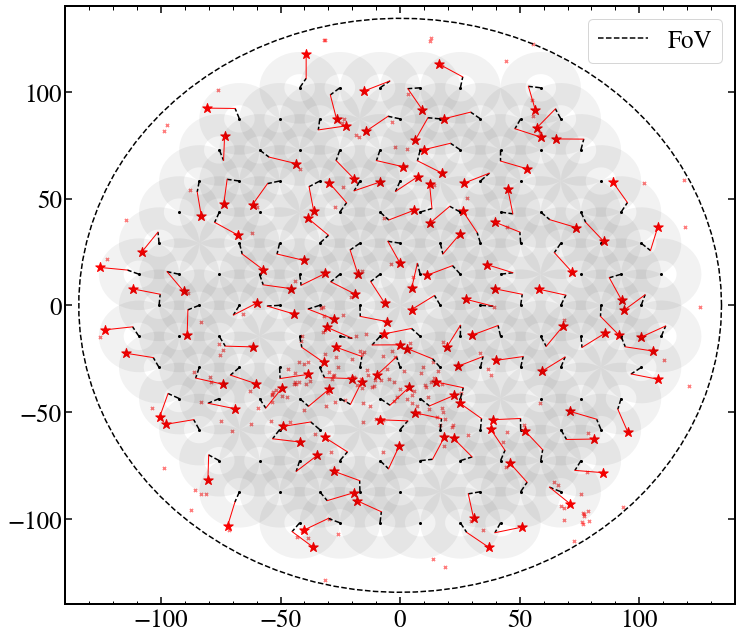

In [54]:
#configuration ������

alpha_length=5.2
beta_length=11.6

xx=np.array(obj_3_assigned['x']-obj_3_assigned['fiber_x'])
yy=np.array(obj_3_assigned['y']-obj_3_assigned['fiber_y'])
r=np.sqrt(xx*xx+yy*yy)
ang=np.arctan2(yy,xx)

beta=np.arccos((r*r-alpha_length**2-beta_length**2)/2/alpha_length/beta_length)  # 0 ~ pi
alpha=ang-np.arccos((alpha_length+beta_length*np.cos(beta))/r) # -pi ~ pi

plt.figure(figsize=(12,11))

for i in range(len(obj_3_assigned)):
    x=obj_3_assigned['fiber_x'][i]
    y=obj_3_assigned['fiber_y'][i]
    xx1=[x,x+np.cos(alpha[i])*alpha_length]
    xx2=[x+np.cos(alpha[i])*alpha_length,x+np.cos(alpha[i])*alpha_length+np.cos(beta[i]+alpha[i])*beta_length]
    yy1=[y,y+np.sin(alpha[i])*alpha_length]
    yy2=[y+np.sin(alpha[i])*alpha_length,y+np.sin(alpha[i])*alpha_length+np.sin(beta[i]+alpha[i])*beta_length]    
    plt.plot(xx1,yy1,'k--')
    plt.plot(xx2,yy2,'r',lw=1)
    
    
plt.scatter(fiber_pos['x'],fiber_pos['y'],s=4,color='k')  
plt.scatter(np.array(objx['x']),np.array(objx['y']),marker='x',color='r',s=10,alpha=0.5)

theta=np.linspace(0,2*np.pi,100)
plt.plot(16.8*8*np.cos(theta),16.8*8*np.sin(theta),'k--',label='FoV')

plt.scatter(obj_3_assigned['x'],obj_3_assigned['y'],marker='*',color='r',s=100)

for i in range(len(fiber_pos)):
    n, radii = 50, [6.4, 16.8]
    theta = np.linspace(0, 2*np.pi, n)
    xs = np.outer(radii, np.cos(theta))+fiber_pos['x'][i]
    ys = np.outer(radii, np.sin(theta))+fiber_pos['y'][i]

    xs[1,:] = xs[1,::-1]
    ys[1,:] = ys[1,::-1]

    plt.fill(np.ravel(xs), np.ravel(ys),color='k',alpha=0.05,edgecolor=None)

plt.xlim(-140,140)
plt.ylim(-140,140)

plt.legend()
plt.show()

# Enhanced mode

In [49]:
alpha_length=5.2 
beta_length=11.6 
col_cond=3.5
thread_num=8
max_loop=1e7

In [50]:
def func_fib_items(fib_op,fiber_pos_3,obj_3,obj_3_assigned):
    obj_assi_idx=obj_3_assigned['idx']
    obj_assi_fibnum=np.array(obj_3_assigned['fiber_num'])
    fib_op_adj=[]    
    items = []
    assi_idx_opfib=[]                  
    for i in range(len(fib_op)):  
        items.append(fiber_pos_3['obj_cand'][fib_op[i]].copy())
        items[i].append(-1-i) # negative sign: unassigned fiber
        fib_op_adj.extend(fiber_pos_3['adj_fib_idx'][fib_op[i]].copy())
        idxx=np.where(obj_assi_fibnum==fib_op[i]+1)[0]
        if len(idxx) !=0:
            assi_idx_opfib.append(obj_assi_idx[idxx[0]])        

    fib_op_adj=list(np.unique(fib_op_adj))

    for i in fib_op:
        if i in fib_op_adj:
            fib_op_adj.remove(i)   

    for i in range(len(items)):
        for j in range(len(obj_assi_idx)):
            if obj_assi_idx[j] not in assi_idx_opfib: # assi_idx_opfib : fib_op 에 의해 assigned된 target idx
                if obj_assi_idx[j] in items[i]:
                    items[i].remove(obj_assi_idx[j])

    obj_op_group=pd.DataFrame({"x":[],"y":[],"rank":[],"fiber_x":[],"fiber_y":[],"fiber_num":[]})
    for i in range(len(fib_op_adj)):
        obj_op_group=obj_op_group.append(obj_3_assigned[obj_3_assigned['fiber_num']==fib_op_adj[i]+1],ignore_index=True)
        fib=fiber_pos_3.iloc[fib_op_adj[i]]
        obj_op_group['fiber_x'][i]=fib['x']
        obj_op_group['fiber_y'][i]=fib['y']    

    item_remove=[]
    for i in range(len(fib_op)):
        item_remove.append([])

    for i in range(len(fib_op)):
        for j in range(len(items[i])-1):

            groupi=obj_op_group.copy()

            objjjj=obj_3.iloc[items[i][j]]
            fib=fiber_pos_3.iloc[int(fib_op[i])]
            new_dat={"x":objjjj['x'],"y":objjjj['y'],"rank":objjjj['rank'],"fiber_x":fib['x'],"fiber_y":fib['y'],"fiber_num":fib_op[i]+1}
            groupi=groupi.append(new_dat,ignore_index=True)
            groupi_fib_num=list(groupi['fiber_num'])

            xx=np.array(groupi['x']-groupi['fiber_x'])
            yy=np.array(groupi['y']-groupi['fiber_y'])
            r=np.sqrt(xx*xx+yy*yy)
            ang=np.arctan2(yy,xx)

            beta=np.arccos((r*r-alpha_length**2-beta_length**2)/2/alpha_length/beta_length)  # 0 ~ pi
            alpha=ang-np.arccos((alpha_length+beta_length*np.cos(beta))/r) # -pi ~ pi        

            x1=groupi['fiber_x'][len(groupi)-1]
            y1=groupi['fiber_y'][len(groupi)-1]
            a1=np.array([x1+np.cos(alpha[len(groupi)-1])*alpha_length,y1+np.sin(alpha[len(groupi)-1])*alpha_length])
            b1=np.array([x1+np.cos(alpha[len(groupi)-1])*alpha_length+np.cos(beta[len(groupi)-1]+alpha[len(groupi)-1])*beta_length,y1+np.sin(alpha[len(groupi)-1])*alpha_length+np.sin(beta[len(groupi)-1]+alpha[len(groupi)-1])*beta_length])

            for l in range(len(groupi)-1):
                ind=adj_fib[int(groupi_fib_num[len(groupi)-1]-1)].copy()
                ind.append(int(groupi_fib_num[l]-1))

                if len(ind)!= len(set(ind)): 
                    x2=groupi['fiber_x'][l]
                    y2=groupi['fiber_y'][l]  
                    a2=np.array([x2+np.cos(alpha[l])*alpha_length,y2+np.sin(alpha[l])*alpha_length])
                    b2=np.array([x2+np.cos(alpha[l])*alpha_length+np.cos(beta[l]+alpha[l])*beta_length,y2+np.sin(alpha[l])*alpha_length+np.sin(beta[l]+alpha[l])*beta_length])

                    if line_cross(a1,b1,a2,b2) : dist=[0,0,0,0]

                    else :
                        dist=[line2pointdist(a1,a2,b2)
                                ,line2pointdist(a2,a1,b1)
                                ,line2pointdist(b1,a2,b2)
                                ,line2pointdist(b2,a1,b1)]

                    if (dist[0]<(col_cond*np.sqrt(2)+col_cond)/2) | (dist[1]<(col_cond*np.sqrt(2)+col_cond)/2) | (dist[2]<col_cond) | (dist[3]<col_cond):
                        item_remove[i].append(items[i][j])
                        break

    for i in range(len(item_remove)):
        for j in item_remove[i]:
            items[i].remove(j)    
    return items

In [51]:
def proc_opt(obj,fiber_pos,thread_num,max_loop,order=3,alpha_length=5.2,beta_length=11.6,col_cond=3,pre_assigned=None):

    global fiber_pos_3
    global obj_3
    
    fiber_pos_3=fiber_pos.copy(deep=True)
    obj_3=obj.copy(deep=True)
    obj_3['fiber_cand']=""
    obj_3_assigned=pd.DataFrame({"x":[],"y":[],"rank":[],"fiber_x":[],"fiber_y":[],"fiber_num":[],"idx":[],"flag":[]})
    if pre_assigned is not None:
        obj_3_assigned=obj_3_assigned.append(pre_assigned,ignore_index=True)

    obj_fib=[]
    for i in range(len(obj_3)):
        fib=[]
        idx=np.where((abs(np.array(fiber_pos_3['x'])-obj_3['x'][i])<=16.8) &(abs(np.array(fiber_pos_3['y'])-obj_3['y'][i])<=16.8))
        for j in idx[0]:
            dist=pow(fiber_pos_3['x'][j]-obj_3['x'][i],2)+pow(fiber_pos_3['y'][j]-obj_3['y'][i],2)
            if (dist>40.96) & (dist<282.24): #40.96=6.4^2 , 282.24=16.8^2
                fib.append(j)
        obj_fib.append(fib)

    if pre_assigned is not None:
        for i in obj_fib:
            for j in np.array(pre_assigned['fiber_num']):
                if j-1 in i:
                    i.remove(j-1)


    obj_3['fiber_cand']=obj_fib ### 3 rev.

    objjj=[]
    for i in range(len(fiber_pos_3)):
        objj=[]
        idx=np.where((abs(np.array(obj_3['x'])-fiber_pos_3['x'][i])<=16.8) &(abs(np.array(obj_3['y'])-fiber_pos_3['y'][i])<=16.8))
        for j in idx[0]:
            dist=pow(fiber_pos_3['x'][i]-obj_3['x'][j],2)+pow(fiber_pos_3['y'][i]-obj_3['y'][j],2)
            if (dist>40.96) & (dist<282.24): #40.96=6.4^2 , 282.24=16.8^2
                objj.append(j)
        objjj.append(objj)

    if pre_assigned is not None:
        for j in np.array(pre_assigned['fiber_num']):
            objjj[int(j-1)]=[]

    fiber_pos_3['obj_cand']=objjj  
    
    fib=np.arange(0,150,1)
    fib_items=fiber_pos_3['obj_cand']
    col_list=collision_list(obj_3,fib,adj_fib,fiber_pos_3,fib_items,alpha_length,beta_length,col_cond)

    group=[]
    for i in range(len(col_list)):
        fib_g=list(np.array(fib)[np.where(col_list[i]!=0)])
        if fib_g not in group:
            group.append(fib_g)

        while True:
            if len(group)<=1:break
            ii=0
            for i in range(len(group)):
                for j in range(i+1,len(group)):
                    gg=np.concatenate((group[i],group[j]))
                    if len(gg)!=len(set(gg)):
                        group.pop(j)
                        group.pop(i)
                        group.append(list(np.unique(gg)))
                        ii=1
                        break
                if ii:
                    break

            if (i==len(group)-1) & (j==len(group)-1):
                break
                
    group_opt=[]
    unassigned_fib=[]
    for i in range(len(group)):
        a=1
        for j in group[i]:
            a*=len(fiber_pos_3['obj_cand'][j])+1
        if a<max_loop:#a<1e8:
            group_opt.append(group[i])
        else :
            unassigned_fib.extend(group[i])

    result_opt=group_proc3(group_opt,thread_num,obj_3,obj_3_assigned,thread_num,max_loop,alpha_length,beta_length,col_cond)
    for i in range(len(result_opt[0])):
        for j in range(len(result_opt[1][i])):
            if result_opt[1][i][j]>0:
                objjj=obj_3.iloc[int(result_opt[1][i][j])]
                fib=fiber_pos_3.iloc[int(result_opt[0][i][j])]
                new_dat={"x":objjj['x'],"y":objjj['y'],"rank":objjj['rank'],"fiber_x":fib['x'],"fiber_y":fib['y'],"fiber_num":fib['fiber_num'],"idx":result_opt[1][i][j]}
                obj_3_assigned=obj_3_assigned.append(new_dat,ignore_index=True)
    
    fibb=np.arange(0,150,1)
    grouppp=[]
    for i in range(len(group)):
        grouppp.extend(list(group[i]))

    for i in fibb:
        if i not in grouppp:
            obj_cand=fiber_pos_3['obj_cand'][i]
            obj_rank=[]
            for j in obj_cand:
                obj_rank.append(obj_3['rank'][j])
            if len(obj_rank)!=0:
                idx_obj=np.where(obj_rank==min(obj_rank))[0][0]
                objjj=obj_3.iloc[obj_cand[idx_obj]]
                fib=fiber_pos_3.iloc[i]
                new_dat={"x":objjj['x'],"y":objjj['y'],"rank":objjj['rank'],"fiber_x":fib['x'],"fiber_y":fib['y'],"fiber_num":fib['fiber_num'],"idx":obj_cand[idx_obj]}
                obj_3_assigned=obj_3_assigned.append(new_dat,ignore_index=True)

    gggroup=copy.deepcopy(group)
    pre_assigned=obj_3_assigned.copy(deep=True)
    pre_assigned['flag']=1 #

    obj_3_assigned,fiber_pos_3,obj_3=proc1(obj,fiber_pos,pre_assigned)
    #obj_3_assigned,_,_=proc1(obj,fiber_pos,pre_assigned)
    #obj_3 = obj_3.iloc[1:]
    #obj_3=obj_3.reset_index()
    
    obj_assigned_nan=obj_3_assigned[np.isnan(obj_3_assigned['flag'])]
    for i in range(len(obj_3_assigned[np.isnan(obj_3_assigned['flag'])])):
        if int(obj_assigned_nan.iloc[i]['fiber_num']-1) not in unassigned_fib:
            obj_3_assigned=obj_3_assigned.drop(obj_assigned_nan.index[i])

    obj_3_assigned=obj_3_assigned.reset_index(drop=True)

    orig_assigned=obj_3_assigned.copy(deep=True)
    group=proc2(obj_3,obj_3_assigned,fiber_pos_3,alpha_length,beta_length,col_cond)

    
    group_op_i=group
    opt_max_cond=max_loop
    thread_op_i=thread_num
    for m in range(len(group)):
        obj_assi_idx=obj_3_assigned['idx']
        obj_assi_fibnum=np.array(obj_3_assigned['fiber_num'])
        fib_op=[]
        fib_op_items=[]
        fib_op.append(list(group_op_i[m].copy()))

        op_remove=[]
        for i in fib_op[0]:
            if i not in unassigned_fib:
                op_remove.append(i)
        for i in op_remove:
            fib_op[0].remove(i)

        fib_op_items.append(func_fib_items(fib_op[0],fiber_pos_3,obj_3,obj_3_assigned))
        itr=-1
        while True:
            itr+=1
            if itr==order:break
                
            fib_op_append=copy.deepcopy(fib_op[itr])
            fib_op_adj=[]
            for i in range(len(fib_op[itr])): 
                fib_op_adj.extend(fiber_pos_3['adj_fib_idx'][fib_op[itr][i]].copy())
            fib_op_adj=list(np.unique(fib_op_adj))

            for i in fib_op[itr]:
                if i in fib_op_adj:
                    fib_op_adj.remove(i)

            fib_append_cand=pd.DataFrame({"x":[],"y":[],"rank":[],"fiber_x":[],"fiber_y":[],"fiber_num":[]})
            for i in range(len(fib_op_adj)):
                fib_a=obj_3_assigned[(obj_3_assigned['fiber_num']==fib_op_adj[i]+1)&(np.isnan(obj_3_assigned['flag']))]
                fib_append_cand=fib_append_cand.append(fib_a,ignore_index=True)

                if len(fib_a)==0:
                    dist=[]
                    adj_x=fiber_pos_3['x'][fib_op_adj[i]]
                    adj_y=fiber_pos_3['y'][fib_op_adj[i]]
                    for j in range(len(fib_op[itr])):
                        op_x=fiber_pos_3['x'][fib_op[itr][j]]
                        op_y=fiber_pos_3['y'][fib_op[itr][j]]
                        dist.append(pow(adj_x-op_x,2)+pow(adj_y-op_y,2))
                    if min(dist)<16.8*16.8+0.1:
                        fib_op_append.append(fib_op_adj[i])
                        
            xx=np.array(fib_append_cand['x']-fib_append_cand['fiber_x'])
            yy=np.array(fib_append_cand['y']-fib_append_cand['fiber_y'])
            r=np.sqrt(xx*xx+yy*yy)
            ang=np.arctan2(yy,xx)

            beta=np.arccos((r*r-alpha_length**2-beta_length**2)/2/alpha_length/beta_length)  # 0 ~ pi
            alpha=ang-np.arccos((alpha_length+beta_length*np.cos(beta))/r) # -pi ~ pi        
            for i in range(len(fib_append_cand)):        
                x1=fib_append_cand['fiber_x'][i]
                y1=fib_append_cand['fiber_y'][i]
                a1=np.array([x1+np.cos(alpha[i])*alpha_length,y1+np.sin(alpha[i])*alpha_length])
                b1=np.array([x1+np.cos(alpha[i])*alpha_length+np.cos(beta[i]+alpha[i])*beta_length,y1+np.sin(alpha[i])*alpha_length+np.sin(beta[i]+alpha[i])*beta_length])

                dist=[]
                for j in range(len(fib_op[itr])):
                    fib_x=fiber_pos_3['x'][int(fib_op[itr][j])]
                    fib_y=fiber_pos_3['y'][int(fib_op[itr][j])]
                    dist.append(sum((a1-np.array([fib_x,fib_y]))**2))
                    dist.append(sum((b1-np.array([fib_x,fib_y]))**2))
                if min(dist)<16.8*16.8:
                    fib_op_append.append(int(fib_append_cand['fiber_num'][i]-1))

            op_remove=[]
            for i in fib_op_append:
                if i not in unassigned_fib:
                    op_remove.append(i)
            for i in op_remove:
                fib_op_append.remove(i)

            fib_items_cand=func_fib_items(fib_op_append,fiber_pos_3,obj_3,obj_3_assigned)

            break_cond=1
            for i in fib_items_cand:
                break_cond*=len(i)
            
            if break_cond>opt_max_cond:
                break
            else:
                fib_op.append(fib_op_append)
                fib_op_items.append(fib_items_cand)

    #####
        fib_op=fib_op[-1]
        items=fib_op_items[-1]

        max_cond=1
        for i in items:
            max_cond*=len(i)

        if  (len(fib_op)>9) & (max_cond>1e6):
            fib_op=np.array(fib_op)
            co=pd.DataFrame({"x":fiber_pos_3['x'][fib_op], "y":fiber_pos_3['y'][fib_op]})
            kmeans = KMeans(n_clusters=2)
            kmeans.fit(co)
            subgroup_idx=kmeans.labels_
            boundary=set_group_boundary(fiber_pos_3,fib_op,subgroup_idx)

            boundary_idx=[]
            for i in boundary:
                boundary_idx.append(np.where(fib_op==i)[0][0]) 

            boundary_items=[]
            for i in boundary_idx:
                boundary_items.append(items[i])

            boundary_combinations=np.array(list(product(*boundary_items)))   

            boundary_col_list=collision_list(obj_3,fib_op[np.array(boundary_idx)],adj_fib,fiber_pos_3,boundary_items,alpha_length,beta_length,col_cond)            
                ###    
            iii=0
            if len(boundary_combinations)<thread_num:
                thread_numm=thread_num
                thread_num=len(boundary_combinations)
                iii+=1
            boundary_comb_split=np.array_split(boundary_combinations,thread_num)
            boundary_assi_len_split=[np.zeros(len(boundary_comb_split[i])) for i in range(thread_num)]
            pool = ProcessPoolExecutor(max_workers=thread_num)
            futures=[]
            for i in range(thread_num):
                futures.append(pool.submit(col_av,boundary_comb_split[i],boundary_assi_len_split[i],boundary_col_list))

            done, not_done = wait(futures, return_when=ALL_COMPLETED)
            pool.shutdown(wait=False)
            kill_child_processes(os.getpid())

            boundary_combinations=futures[0].result()[0]
            boundary_assi_len=futures[0].result()[1]
            for i in range(thread_num-1):
                boundary_combinations=np.concatenate([boundary_combinations,futures[i+1].result()[0]])
                boundary_assi_len=np.concatenate([boundary_assi_len,futures[i+1].result()[1]])

            if iii==1:
                thread_num=thread_numm
                iii=0                


            boundary_combinations_split=np.array_split(boundary_combinations,thread_num)

            pool = ProcessPoolExecutor(max_workers=thread_num)
            futures=[]
            for i in range(thread_num):
                futures.append(pool.submit(col_av2,obj_3,obj_3_assigned,subgroup_idx,boundary_idx,boundary,boundary_combinations_split[i],fib_op,items,fiber_pos_3,adj_fib,alpha_length,beta_length,col_cond))

            done, not_done = wait(futures, return_when=ALL_COMPLETED)
            pool.shutdown(wait=False)
            kill_child_processes(os.getpid())      


            fib0_op,fib1_op,result_combinations,result_assi_len,result1_combinations,result1_assi_len=futures[0].result()

            for i in range(thread_num-1):
                a,b,c,d=futures[i+1].result()[2:]
                result_combinations.extend(a)
                result_assi_len.extend(b)
                result1_combinations.extend(c)
                result1_assi_len.extend(d)

            boundary_assi_len=[]
            for i in range(len(boundary_combinations)):
                boundary_assi_len.append(len(np.where(boundary_combinations[i]>0)[0]))
            tot_assi_len=np.array(boundary_assi_len)+np.array(result_assi_len)+np.array(result1_assi_len)  

            orig=[]
            for i in boundary:
                idx=np.where(obj_assi_fibnum==i+1)
                if len(idx[0])!=0:
                    orig.append(np.array(obj_assi_idx)[idx][0])
                else :
                    orig.append(0)   

            for i in fib0_op:
                idx=np.where(obj_assi_fibnum==i+1)
                if len(idx[0])!=0:
                    orig.append(np.array(obj_assi_idx)[idx][0])
                else :
                    orig.append(0)

            for i in fib1_op:
                idx=np.where(obj_assi_fibnum==i+1)
                if len(idx[0])!=0:
                    orig.append(np.array(obj_assi_idx)[idx][0])
                else :
                    orig.append(0)
            orig=np.array(orig)

            idx=np.where(tot_assi_len==max(tot_assi_len))
            arr=np.append(boundary_combinations[idx],np.array(result_combinations)[idx],axis=1)
            comb=np.append(arr,np.array(result1_combinations)[idx],axis=1)


            comb_orig=np.append(np.where(comb-orig!=0)[0],np.arange(0,len(comb)))
            comb_cond=np.array(Counter(comb_orig).most_common())
            comb2=comb[comb_cond.T[0][np.where(comb_cond.T[1]==min(comb_cond.T[1]))[0][0]]]                    
            arr=np.append(boundary,fib0_op)
            arr=np.append(arr,fib1_op)
            result_comb=comb2
            result_fib=arr

        else:
            col_list=collision_list(obj_3,fib_op,adj_fib,fiber_pos_3,items,alpha_length,beta_length,col_cond)
            combinations=list(product(*items)) 
            iii=0
            if len(combinations)<thread_op_i:
                thread_op_ii=thread_op_i
                thread_op_i=len(combinations)
                iii+=1
            comb_split=np.array_split(combinations,thread_op_i)
            assi_len=[np.zeros(len(comb_split[i])) for i in range(thread_op_i)]
            pool = ProcessPoolExecutor(max_workers=thread_op_i)
            futures=[]
            for i in range(thread_op_i):
                futures.append(pool.submit(col_av,comb_split[i],assi_len[i],col_list))

            done, not_done = wait(futures, return_when=ALL_COMPLETED)
            pool.shutdown(wait=False)
            kill_child_processes(os.getpid())

            result_comb=futures[0].result()[0]
            result_assi_len=futures[0].result()[1]
            for i in range(thread_op_i-1):
                result_comb=np.concatenate([result_comb,futures[i+1].result()[0]])
                result_assi_len=np.concatenate([result_assi_len,futures[i+1].result()[1]])

            orig=[]
            for i in fib_op:
                idx=np.where(obj_assi_fibnum==i+1)
                if len(idx[0])!=0:
                    orig.append(np.array(obj_assi_idx)[idx][0])
                else :
                    orig.append(0)
            orig=np.array(orig)

            comb=result_comb[np.where(result_assi_len==max(result_assi_len))[0]] 
            comb_orig=np.append(np.where(comb-orig!=0)[0],np.arange(0,len(comb)))
            comb_cond=np.array(Counter(comb_orig).most_common())
            comb2=comb[comb_cond.T[0][np.where(comb_cond.T[1]==min(comb_cond.T[1]))[0][0]]]            
            result_comb=comb2
            result_fib=np.array(fib_op)
            if iii==1:
                thread_op_i=thread_op_ii
                iii=0
        for i in range(len(result_fib)):
            obj_3_assigned=obj_3_assigned.drop(obj_3_assigned[obj_3_assigned['fiber_num']==result_fib[i]+1].index)
            if result_comb[i]>0:
                objjj=obj_3.iloc[int(result_comb[i])]
                fib=fiber_pos_3.iloc[int(result_fib[i])]
                new_dat={"x":objjj['x'],"y":objjj['y'],"rank":objjj['rank'],"fiber_x":fib['x'],"fiber_y":fib['y'],"fiber_num":fib['fiber_num'],"idx":result_comb[i]}
                obj_3_assigned=obj_3_assigned.append(new_dat,ignore_index=True) 
        obj_3_assigned=obj_3_assigned.reset_index(drop=True)
    return obj_3,fiber_pos_3,obj_3_assigned

In [56]:
test1 = pd.read_csv('./test_object.csv')
### Include a dummy target (fix needed)
test1=test1.append(objx.iloc[0],ignore_index=True)
test1.iloc[0]['x']=150
test1.iloc[0]['y']=150
test1.iloc[0]['rank']=150
###

#enhanced mode
order=3 
obj_3,fiber_pos_3,obj_3_assigned=proc_opt(test1,fiber_pos,thread_num,max_loop,order,alpha_length,beta_length,col_cond)

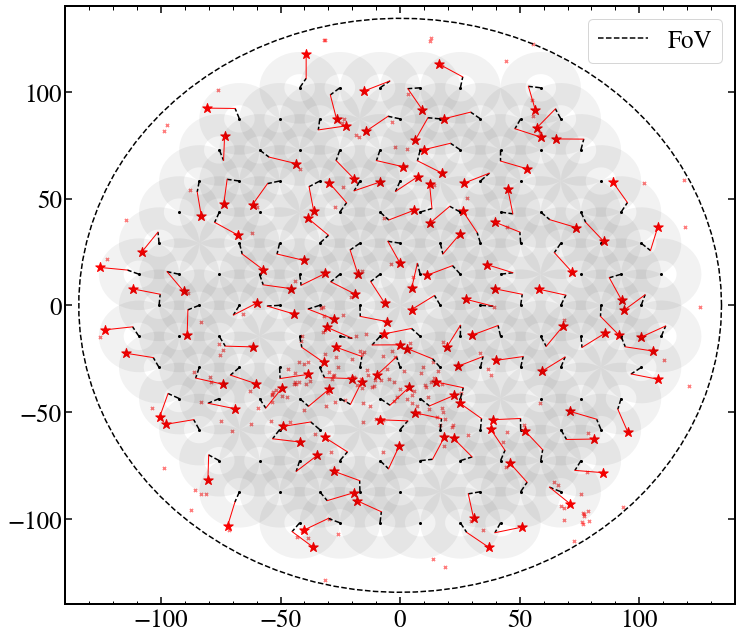

In [57]:
#configuration ������

alpha_length=5.2
beta_length=11.6

xx=np.array(obj_3_assigned['x']-obj_3_assigned['fiber_x'])
yy=np.array(obj_3_assigned['y']-obj_3_assigned['fiber_y'])
r=np.sqrt(xx*xx+yy*yy)
ang=np.arctan2(yy,xx)

beta=np.arccos((r*r-alpha_length**2-beta_length**2)/2/alpha_length/beta_length)  # 0 ~ pi
alpha=ang-np.arccos((alpha_length+beta_length*np.cos(beta))/r) # -pi ~ pi

plt.figure(figsize=(12,11))

for i in range(len(obj_3_assigned)):
    x=obj_3_assigned['fiber_x'][i]
    y=obj_3_assigned['fiber_y'][i]
    xx1=[x,x+np.cos(alpha[i])*alpha_length]
    xx2=[x+np.cos(alpha[i])*alpha_length,x+np.cos(alpha[i])*alpha_length+np.cos(beta[i]+alpha[i])*beta_length]
    yy1=[y,y+np.sin(alpha[i])*alpha_length]
    yy2=[y+np.sin(alpha[i])*alpha_length,y+np.sin(alpha[i])*alpha_length+np.sin(beta[i]+alpha[i])*beta_length]    
    plt.plot(xx1,yy1,'k--')
    plt.plot(xx2,yy2,'r',lw=1)
    
    
plt.scatter(fiber_pos['x'],fiber_pos['y'],s=4,color='k')  
plt.scatter(np.array(objx['x']),np.array(objx['y']),marker='x',color='r',s=10,alpha=0.5)

theta=np.linspace(0,2*np.pi,100)
plt.plot(16.8*8*np.cos(theta),16.8*8*np.sin(theta),'k--',label='FoV')

plt.scatter(obj_3_assigned['x'],obj_3_assigned['y'],marker='*',color='r',s=100)

for i in range(len(fiber_pos)):
    n, radii = 50, [6.4, 16.8]
    theta = np.linspace(0, 2*np.pi, n)
    xs = np.outer(radii, np.cos(theta))+fiber_pos['x'][i]
    ys = np.outer(radii, np.sin(theta))+fiber_pos['y'][i]

    xs[1,:] = xs[1,::-1]
    ys[1,:] = ys[1,::-1]

    plt.fill(np.ravel(xs), np.ravel(ys),color='k',alpha=0.05,edgecolor=None)

plt.xlim(-140,140)
plt.ylim(-140,140)

plt.legend()
plt.show()